# __Analisis de Evasion de Clientes__

## Librerias

In [52]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns

In [53]:
import numexpr
print(numexpr.__version__)

2.11.0


## Extraccion de datos

### Importar Datos

In [54]:
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

df = pd.read_json(url)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


Como vemos, hay varias variables que contienen diccionarios en sus valores. Por tanto, debemos expandirlas

In [55]:
# expandir cada variable
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

In [56]:
# seleccionar variables no expandidas de df
df = df[['customerID', 'Churn']]

In [57]:
# unir todos los dfs en uno
df_exp = pd.concat([df, df_customer, df_phone, df_internet, df_account], axis=1)
df_exp.head(5)

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


### Contexto de los datos

Se tratan de datos de los clientes de una empresa cuya informacion de cada variable se interpreta como:

- _customerID_: número de identificación único de cada cliente
- _Churn_: si el cliente dejó o no la empresa
- _gender_: género (masculino y femenino)
- _SeniorCitizen_: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- _Partner_: si el cliente tiene o no una pareja
- _Dependents_: si el cliente tiene o no dependientes
- _tenure_: meses de contrato del cliente
- _PhoneService_: suscripción al servicio telefónico
- _MultipleLines_: suscripción a más de una línea telefónica
- _InternetService_: suscripción a un proveedor de internet
- _OnlineSecurity_: suscripción adicional de seguridad en línea
- _OnlineBackup_: suscripción adicional de respaldo en línea
- _DeviceProtection_: suscripción adicional de protección del dispositivo
- _TechSupport_: suscripción adicional de soporte técnico, menor tiempo de espera
- _StreamingTV_: suscripción de televisión por cable
- _StreamingMovies_: suscripción de streaming de películas
- _Contract_: tipo de contrato
- _PaperlessBilling_: si el cliente prefiere recibir la factura en línea
- _PaymentMethod_: forma de pago
- _Charges.Monthly_: total de todos los servicios del cliente por mes
- _Charges.Total_: total gastado por el cliente

### Tipo de datos

In [58]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


> El conjunto de datos esta conformado por 7267 registros y 21 variables.

> Todas las variables tienen 7267 registros lo que indica la ausencia de valores faltantes.

> Las variables 'SeniorCitizen' y 'tenure' son de tipo entero, la variable 'Charges.Monthly' es de tipo float y el resto de variables son de tipo object.

> La variable 'Charges.Total' y 'Churn' en la practica son de tipo numerico. Sin embargo, Pandas las detecta de tipo object lo que sugiere un problema con la consistencia de los datos.

## Consistencia de los datos

### Registros duplicados

In [59]:
# verificar registros duplicados
df_exp.duplicated().sum()

0

> No hay registros duplicados en el dataframe.

### Tratar valores vacios

Verificamos los valores de 'Churn' y 'Charges.Total'

In [60]:
print('Charges.Total: ',df_exp['Charges.Total'].unique())
print('Churn: ',df_exp.Churn.unique())

Charges.Total:  ['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']
Churn:  ['No' 'Yes' '']


> Los valores de _Churn_ y _Charges.Total_ presentan valores vacios por lo que procedemos a tratarlos

__Churn__

In [61]:
# registros con valores vacios en _Churn_
df_exp[df_exp['Churn'] == ''].shape

(224, 21)

> Hay 224 registros con valores vacios en _Churn_ lo que representa el 3% de los registros totales. Como la variable objetivo es _Churn_, sin esta informacion tales registros no aportan al analisis por tanto los eliminamos.

In [62]:
# elimina registros con Churn vacios
df_exp = df_exp[df_exp['Churn'] != '']
df_exp.shape

(7043, 21)

In [63]:
# verificar que Churn este libre de valores vacios
print(df_exp.Churn.unique())

['No' 'Yes']


__Charges.Total__

In [64]:
# registros vacios en Charges.Total
df_exp[df_exp['Charges.Total'] == ' ']

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
975,1371-DWPAZ,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
1775,2520-SGTTA,No,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,
1955,2775-SEFEE,No,Male,0,No,Yes,0,Yes,Yes,DSL,...,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
2075,2923-ARZLG,No,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
2232,3115-CZMZD,No,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2308,3213-VVOLG,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
2930,4075-WKNIU,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,
3134,4367-NUYAO,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,
3203,4472-LVYGI,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
4169,5709-LVOEQ,No,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,


> Hay 11 registros con valores vacios en Charges.Total lo que representa el 0.1% de los registros totales. Al visualizarlos, nos damos cuenta que corresponden a clientes con contratos largos pero que no tienen ni el primer mes cumplido por lo que no aportan informacion relevante al estudio. Los eliminamos

In [65]:
# elimina registros con Charges.Total vacios
df_exp = df_exp[df_exp['Charges.Total'] != ' ']
df_exp.shape

(7032, 21)

In [66]:
# verificar que Churn este libre de valores vacios
print(df_exp['Charges.Total'].unique())

['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']


In [67]:
import numpy as np 

# convertir a tipo entero
df_exp['Charges.Total'] = df_exp['Charges.Total'].astype(np.float64)

# verificar tipo
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   object 
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   object 
 5   Dependents        7032 non-null   object 
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  Contract          7032 non-null   object 
 17  

### Columna de cuentas diarias

In [68]:
# crear columna de gasto diario de cada cliente
df_exp['Cuentas_Diarias'] = (df_exp['Charges.Monthly'])/(df_exp['tenure']*30)
df_exp.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0.242963
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0.221852
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,0.615833
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,0.251282
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,0.932222


### Estandarizacion de los datos

Vamos a realizar las conversiones de los valores de las variables necesarias para mejorar la interpretacion de los resultados.

__Valores Unicos por variable__

In [69]:
# verificar valores de variables de tipo object
print('gender: ',df_exp.gender.unique())
print('SeniorCitizen: ',df_exp.SeniorCitizen.unique())
print('Partner: ',df_exp.Partner.unique())
print('Dependents: ',df_exp.Dependents.unique())
print('PhoneService: ',df_exp.PhoneService.unique())
print('MultipleLines: ',df_exp.MultipleLines.unique())
print('InternetService: ',df_exp.InternetService.unique())
print('OnlineSecurity: ',df_exp.OnlineSecurity.unique())
print('OnlineBackup: ',df_exp.OnlineBackup.unique())
print('DeviceProtection: ',df_exp.DeviceProtection.unique())
print('TechSupport: ',df_exp.TechSupport.unique())
print('StreamingTV: ',df_exp.StreamingTV.unique())
print('StreamingMovies: ',df_exp.StreamingMovies.unique())
print('Contract: ',df_exp.Contract.unique())
print('PaperlessBilling: ',df_exp.PaperlessBilling.unique())
print('PaymentMethod: ',df_exp.PaymentMethod.unique())
print('Charges.Total: ',df_exp['Charges.Total'].unique())
print('Churn: ',df_exp.Churn.unique())

gender:  ['Female' 'Male']
SeniorCitizen:  [0 1]
Partner:  ['Yes' 'No']
Dependents:  ['Yes' 'No']
PhoneService:  ['Yes' 'No']
MultipleLines:  ['No' 'Yes' 'No phone service']
InternetService:  ['DSL' 'Fiber optic' 'No']
OnlineSecurity:  ['No' 'Yes' 'No internet service']
OnlineBackup:  ['Yes' 'No' 'No internet service']
DeviceProtection:  ['No' 'Yes' 'No internet service']
TechSupport:  ['Yes' 'No' 'No internet service']
StreamingTV:  ['Yes' 'No' 'No internet service']
StreamingMovies:  ['No' 'Yes' 'No internet service']
Contract:  ['One year' 'Month-to-month' 'Two year']
PaperlessBilling:  ['Yes' 'No']
PaymentMethod:  ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
Charges.Total:  [ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]
Churn:  ['No' 'Yes']


__Cambiar nombre de las variables__

In [70]:
nombres_nuevos = {
    'Churn': 'cancelacion',
    'gender': 'genero',
    'SeniorCitizen': 'jubilado',
    'Partner': 'en_pareja',
    'Dependents': 'dependientes',
    'tenure': 'meses_contrato',
    'PhoneService': 'servicio_telefonico',
    'MultipleLines': 'multiples_lineas',
    'InternetService': 'servicio_internet',
    'OnlineSecurity': 'seguridad_online',
    'OnlineBackup': 'respaldo_online',
    'DeviceProtection': 'proteccion_dispositivo',
    'TechSupport': 'soporte_efectivo',
    'StreamingTV': 'streaming_TV',
    'StreamingMovies': 'streaming_peliculas',
    'Contract': 'tipo_contrato',
    'PaperlessBilling': 'facturacion_electronica',
    'Charges.Monthly': 'cuenta_mensual',
    'Charges.Total': 'cuentas_total',
    'PaymentMethod': 'metodo_pago',
    'Cuentas_Diarias': 'cuentas_diarias'
}

df_exp.rename(columns=nombres_nuevos, inplace=True)

__customerID__

Vamos a omitir customer_ID ya que son identificadores de los clientes que a nivel general no aporta informacion relevante.

In [71]:
# eliminar customerID
df_exp = df_exp.drop('customerID', axis=1)

__genero__

In [72]:
# renombrar valores de genero
df_exp['genero'] = df_exp['genero'].apply(lambda x: x.replace('Female', 'Femenino').replace('Male', 'Masculino'))
df_exp['genero'].unique()

array(['Femenino', 'Masculino'], dtype=object)

__jubilado__

In [73]:
df_exp['jubilado'] = df_exp['jubilado'].map({0:'No', 1:'Si'})
df_exp['jubilado'].unique()

array(['No', 'Si'], dtype=object)

__cancelacion__

In [74]:
# convertir valores de churn a binario
# 0:No esta con la empresa. 1: Sigue en la empresa
df_exp['cancelacion'] = df_exp['cancelacion'].replace({'Yes':'1', 'No':'0'}).astype(np.int64)
df_exp['cancelacion'].unique()

array([0, 1])

__en_pareja__

In [75]:
df_exp['en_pareja'] = df_exp['en_pareja'].map({'Yes':'Si', 'No':'No'})
df_exp.en_pareja.unique()

array(['Si', 'No'], dtype=object)

__dependientes__

In [76]:
df_exp['dependientes'] = df_exp['dependientes'].replace({'Yes':'Si', 'No':'No'})
print(df_exp.dependientes.unique())

['Si' 'No']


__facturacion_electronica__

In [77]:
df_exp['facturacion_electronica'] = df_exp['facturacion_electronica'].replace({'Yes':'Si', 'No':'No'})
print(df_exp.facturacion_electronica.unique())

['Si' 'No']


__servicio_telefonico__

In [78]:
df_exp['servicio_telefonico'] = df_exp['servicio_telefonico'].replace({'Yes':'Si', 'No':'No'})
print(df_exp.servicio_telefonico.unique())

['Si' 'No']


__multiples_lineas__

In [79]:
# agrupamiento de los valores de servicio_telefonico y multiples_lineas
df_exp.groupby(['servicio_telefonico', 'multiples_lineas']).size()

servicio_telefonico  multiples_lineas
No                   No phone service     680
Si                   No                  3385
                     Yes                 2967
dtype: int64

> Los clientes que tienen servicio telefonico necesariamente tienen al menos 1 linea. Los que no tienen servicio telefonico, no tienen linea telefonica. Por tanto, los datos son consistentes.

__servicio_internet__

In [80]:
df_exp['servicio_internet'] = df_exp['servicio_internet'].replace({'Fiber optic':'Fibra_optica'})
df_exp['servicio_internet'].unique()

array(['DSL', 'Fibra_optica', 'No'], dtype=object)

__seguridad_online__

In [81]:
df_exp['seguridad_online'] = df_exp['seguridad_online'].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
df_exp.seguridad_online.unique()

array(['No', 'Si', 'Sin internet'], dtype=object)

In [82]:
df_exp.groupby(['servicio_internet', 'seguridad_online']).size()

servicio_internet  seguridad_online
DSL                No                  1240
                   Si                  1176
Fibra_optica       No                  2257
                   Si                   839
No                 Sin internet        1520
dtype: int64

Los clientes que no tienen servicio de internet, no cuentan con seguridad online. Esto indica que los datos son consistentes.

__respaldo_online__

In [83]:
df_exp['respaldo_online'] = df_exp['respaldo_online'].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
df_exp.respaldo_online.unique()

array(['Si', 'No', 'Sin internet'], dtype=object)

In [84]:
df_exp.groupby(['servicio_internet', 'respaldo_online']).size()

servicio_internet  respaldo_online
DSL                No                 1334
                   Si                 1082
Fibra_optica       No                 1753
                   Si                 1343
No                 Sin internet       1520
dtype: int64

Los clientes que no tienen internet, no cuentan con respaldo online lo que implica que ambas variables son consistentes.

__proteccion_dispositivo, soporte_efectivo, streaming_tv, streaming_peliculas__

__proteccion_dispositivo__

In [85]:
df_exp['proteccion_dispositivo'] = df_exp['proteccion_dispositivo'].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
df_exp.proteccion_dispositivo.unique()

array(['No', 'Si', 'Sin internet'], dtype=object)

In [86]:
df_exp.groupby(['servicio_internet', 'proteccion_dispositivo']).size()

servicio_internet  proteccion_dispositivo
DSL                No                        1355
                   Si                        1061
Fibra_optica       No                        1739
                   Si                        1357
No                 Sin internet              1520
dtype: int64

Los clientes que no tienen internet, no cuentan con proteccion de dispositivo. Son consistentes los datos.

__soporte_efectivo__

In [87]:
df_exp['soporte_efectivo'] = df_exp['soporte_efectivo'].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
df_exp.soporte_efectivo.unique()

array(['Si', 'No', 'Sin internet'], dtype=object)

In [88]:
df_exp.groupby(['servicio_internet', 'soporte_efectivo']).size()

servicio_internet  soporte_efectivo
DSL                No                  1242
                   Si                  1174
Fibra_optica       No                  2230
                   Si                   866
No                 Sin internet        1520
dtype: int64

Clientes sin internet, no cuentan con soporte efectivo. Se comprueba la consistencia de los datos.

__streaming_TV__

In [89]:
df_exp['streaming_TV'] = df_exp['streaming_TV'].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
df_exp.streaming_TV.unique()

array(['Si', 'No', 'Sin internet'], dtype=object)

In [90]:
df_exp.groupby(['servicio_internet', 'soporte_efectivo']).size()

servicio_internet  soporte_efectivo
DSL                No                  1242
                   Si                  1174
Fibra_optica       No                  2230
                   Si                   866
No                 Sin internet        1520
dtype: int64

Clientes sin internet, no cuentan con streaming de TV. Datos consistentes

__streaming_peliculas__

In [91]:


df_exp['streaming_peliculas'] = df_exp['streaming_peliculas'].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
df_exp.streaming_peliculas.unique()

array(['No', 'Si', 'Sin internet'], dtype=object)

In [92]:
df_exp.groupby(['servicio_internet', 'streaming_peliculas']).size()

servicio_internet  streaming_peliculas
DSL                No                     1436
                   Si                      980
Fibra_optica       No                     1345
                   Si                     1751
No                 Sin internet           1520
dtype: int64

Clientes sin internet, no cuentan con streaming de peliculas

__tipo_contrato__

In [93]:
df_exp['tipo_contrato'] = df_exp['tipo_contrato'].replace(
    {'One year':'Un year',
     'Month-to-month':'mes a mes',
     'Two year':'Dos years'
     }
)

df_exp.tipo_contrato.unique()

array(['Un year', 'mes a mes', 'Dos years'], dtype=object)

__metodo_pago__

In [94]:
df_exp['metodo_pago'] = df_exp['metodo_pago'].replace(
    {'Mailed check':'Cheque por correo',
     'Electronic check': 'Cheque electronico',
     'Credit card (automatic)':'Tarjeta de credito',
     'Bank transfer (automatic)':'Transferencia'
     }
    )

df_exp.metodo_pago.unique()

array(['Cheque por correo', 'Cheque electronico', 'Tarjeta de credito',
       'Transferencia'], dtype=object)

In [95]:
df_exp.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,...,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total,cuentas_diarias
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,...,No,Si,Si,No,Un year,Si,Cheque por correo,65.6,593.30,0.242963
1,0,Masculino,No,No,No,9,Si,Yes,DSL,No,...,No,No,No,Si,mes a mes,No,Cheque por correo,59.9,542.40,0.221852
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,...,Si,No,No,No,mes a mes,Si,Cheque electronico,73.9,280.85,0.615833
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,...,Si,No,Si,Si,mes a mes,Si,Cheque electronico,98.0,1237.85,0.251282
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,...,No,Si,Si,No,mes a mes,Si,Cheque por correo,83.9,267.40,0.932222


In [96]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cancelacion              7032 non-null   int64  
 1   genero                   7032 non-null   object 
 2   jubilado                 7032 non-null   object 
 3   en_pareja                7032 non-null   object 
 4   dependientes             7032 non-null   object 
 5   meses_contrato           7032 non-null   int64  
 6   servicio_telefonico      7032 non-null   object 
 7   multiples_lineas         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_online         7032 non-null   object 
 10  respaldo_online          7032 non-null   object 
 11  proteccion_dispositivo   7032 non-null   object 
 12  soporte_efectivo         7032 non-null   object 
 13  streaming_TV             7032 non-null   object 
 14  streaming_peliculas      7032

## Carga y Analisis

### Resumen estadistico de variables categoricas de clientes que cancelan

In [97]:
# lista de variables categoricas
var_categoricas = df_exp.select_dtypes(include=['object', 'category']).columns

# obtener dataframe con variables categoricas mas la variable cancelacion
df_c = df_exp[var_categoricas].copy()
df_c['cancelacion'] = df_exp['cancelacion'].copy()

# seleccionar registros con clientes que cancelaron
df_c_cancelaron = df_c[df_c['cancelacion'] == 1]

# resumen estadistico de las variables categoricas
df_c_cancelaron = df_c_cancelaron.describe(exclude='int')

# trasponer filas por columnas
df_c_cancelaron = df_c_cancelaron.T

# agregar la columna 'proporcion top'
df_c_cancelaron['proporcion_top'] = df_c_cancelaron['freq']/df_c_cancelaron['count']
df_c_cancelaron

,count,unique,top,freq,proporcion_top
genero,1869,2,Femenino,939,0.502408
jubilado,1869,2,No,1393,0.745318
en_pareja,1869,2,No,1200,0.642055
dependientes,1869,2,No,1543,0.825575
servicio_telefonico,1869,2,Si,1699,0.909042
multiples_lineas,1869,3,Yes,850,0.454789
servicio_internet,1869,3,Fibra_optica,1297,0.693954
seguridad_online,1869,3,No,1461,0.781701
respaldo_online,1869,3,No,1233,0.659711
proteccion_dispositivo,1869,3,No,1211,0.64794


> En total, 1869 clientes cancelaron el servicio con la empresa

> La proporcion de hombres y mujeres que cancelaron son similares.

> 74% de los clientes no son adultos mayores.

> 64% de los clientes son solteros.

> 82.5% de los clientes no tienen dependientes a su cargo.

> 91% tienen servicio telefonico

> 45% tiene mas de 1 linea telefonica.

> 69% cuenta con servicio de internet a traves de fibra optica

> 78% no cuenta con seguridad en linea

> 65% no posee respaldo en linea

> 64% no cuenta con proteccion de dispositivos.

> 77% no tienen soporte tecnico efectivo.

> 50% de los clientes no acceden al servicio de streaming TV.

> 50% de los clientes no acceden al servicio de streaming de peliculas.

> El tipo de contrato preferido por estos clientes es el mes a mes.

> La mayoria prefieren facturacion electronica

> EL metodo de pago mas utlizado por este grupo es el cheque electronico.

### Resumen estadistico de variables categoricas de clientes que no cancelan

In [98]:
# lista de variables categoricas
var_categoricas = df_exp.select_dtypes(include=['object', 'category']).columns

# obtener dataframe con variables categoricas mas la variable cancelacion
df_c = df_exp[var_categoricas].copy()
df_c['cancelacion'] = df_exp['cancelacion'].copy()

# seleccionar registros con clientes que  no cancelaron
df_c_Nocancelaron = df_c[df_c['cancelacion'] == 0]

# resumen estadistico de las variables categoricas
df_c_Nocancelaron = df_c_Nocancelaron.describe(exclude='int')

# trasponer filas por columnas
df_c_Nocancelaron = df_c_Nocancelaron.T

# agregar la columna 'proporcion top'
df_c_Nocancelaron['proporcion_top'] = df_c_Nocancelaron['freq']/df_c_Nocancelaron['count']
df_c_Nocancelaron

,count,unique,top,freq,proporcion_top
genero,5163,2,Masculino,2619,0.507263
jubilado,5163,2,No,4497,0.871005
en_pareja,5163,2,Si,2724,0.5276
dependientes,5163,2,No,3390,0.656595
servicio_telefonico,5163,2,Si,4653,0.90122
multiples_lineas,5163,3,No,2536,0.491187
servicio_internet,5163,3,DSL,1957,0.379043
seguridad_online,5163,3,No,2036,0.394344
respaldo_online,5163,3,Si,1902,0.36839
proteccion_dispositivo,5163,3,No,1883,0.36471


> Tenemos 5163 clientes que mantienen el servicio con la empresa

> La proporcion entre hombres y mujeres es igual en este grupo de clientes.

> 87% de los clientes no son adultos mayores.

> 52% estan en pareja.

> 65% no tienen dependientes a su cargo.

> Mas del 90% de los clientes cuentan con servicio telefonico.

> 49% cuentan con al menos 1 linea telefonica.

> 38% de los clientes cuentan con servicio de internet a traves de DSL.

> 39% no cuenta con seguridad online.

> 37% de los clientes cuentan con respaldo online.

> 36% no cuentan con proteccion de dispositivos

> 39% de los clientes no posee soporte tecnico efectivo.

> 36% si cuentan con servicio de streaming TV.

> 37% si cuentan con servicio de streaming de peliculas

> Solo el 43% de estos clientes prefieren el tipo de contrato es mes a mes.

> Mas del 53% reciben facturacion eletronica.

> 25.1% de los clientes prefieren el Cheque por correo como metodo de pago. 

### Resumen estadistico de las variables numericas de clientes que cancelan

In [99]:
df_n_cancelan = df_exp[df_exp['cancelacion'] == 1]
df_n_cancelan = df_n_cancelan.describe()
df_n_cancelan.T

,count,mean,std,min,25%,50%,75%,max
cancelacion,1869.0,1.000000,0.000000,1.000000,1.00,1.000000,1.0000,1.000
meses_contrato,1869.0,17.979133,19.531123,1.000000,2.00,10.000000,29.0000,72.000
cuenta_mensual,1869.0,74.441332,24.666053,18.850000,56.15,79.650000,94.2000,118.350
cuentas_total,1869.0,1531.796094,1890.822994,18.850000,134.50,703.550000,2331.3000,8684.800
cuentas_diarias,1869.0,0.637061,0.808238,0.010601,0.09,0.249306,0.8175,3.415


> En total, hay 1869 clientes que cancelan el servicio con la empresa.

> Aunque en promedio los clientes duren 18 meses, la mayoria cancelan el servicio antes de cumplir 1 año (mediana = 10 meses). La alta dispersion (std = 19 meses) indica una gran variabilidad en el tiempo que toman los clientes antes de cancelar.

> El rango de la cuenta mensual va desde 18.85 a 118.35 con una media de 74.44. En teoria, para una distribucion normal, la media deberia estar cerca 68.85 lo que evidencia una ligera asimetria hacia la izquierda. Muchos de los clientes que cancelan pagan cuentas mensuales medianamente altas.

> La gran diferencia entre la media (1531.79) y la mediana (703.55) en la cuenta total, indica la presencia de outliers, es decir clientes que pagan mucho en cuentas totales. Un valor maximo de 8684.8 y una alta variabilidad (std=1890), reafirma la presencia de valores atipicos.

> La media (0.64) y la mediana (0.25) de la cuenta diaria evidencia una distribucion sesgada a la derecha por la presencia de outliers. Lo que quiere decir es que hay pocos clientes que gastan mucho cada dia.

### Resumen estadistico de las variables numericas de clientes que no cancelan

In [100]:
df_n_Nocancelan = df_exp[df_exp['cancelacion'] == 0]
df_n_Nocancelan = df_n_Nocancelan.describe()
df_n_Nocancelan.T

,count,mean,std,min,25%,50%,75%,max
cancelacion,5163.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
meses_contrato,5163.0,37.650010,24.076940,1.000000,15.000000,38.000000,61.000000,72.000
cuenta_mensual,5163.0,61.307408,31.094557,18.250000,25.100000,64.450000,88.475000,118.750
cuentas_total,5163.0,2555.344141,2329.456984,18.800000,577.825000,1683.600000,4264.125000,8672.450
cuentas_diarias,5163.0,0.160736,0.328574,0.008935,0.036449,0.055444,0.114517,3.195


> En total, 5163 clientes mantienen el servicio con la empresa.

> La mitad de los clientes tienen contratos mayores a 38 meses (mediana=38). Se tratan de clientes leales con mas de 3 años en la empresa. Comparados con los que cancelan, estos clientes duran el doble de tiempo.

> En promedio, estos clientes pagan cuotas mensuales de 61.31 mucho menos que los clientes que cancelan (74.44)

> En promedio los clientes que se mantienen en la empresa gastan mas en cuenta total (2555.34) debido a que llevan mas tiempo con la empresa. 50% de los clientes gastan menos de ese valor total.

> A pesar de tener mas tiempo, estos clientes gastan a diario en promedio menos (0.167) que los que cancelan (0.637). Con una mediana baja (0.055) se intuye que muchos tienen planes economicos o uso moderado del servicio.

### Hipotesis obtenidas a partir del analisis estadistico

1. Aproximadamente 26.6% de los clientes han cancelado el servicio. El resto, permanecen activo.

2. Los clientes que mantienen el servicio tienen contratos mas largos. Mientras que aquellos que cancelan tienen contrato mas cortos posiblemente porque aun estan en etapas tempranas de uso y no estan del todo satisfecho.

3. Clientes con cuentas mensuales altas podrian estar propensos a cancelar el servicio si no ven valor claro.

4. Clientes que han pagado mucho y durante mas tiempo estan mas comprometidos.

5. Altos cargos diarios puede correlacionarse con cancelacion de clientes que los percibe como excesivo.

6. Una mayor tasa de cancelacion podria estar relacionada con clientes que presentan planes mensuales, multiples servicios activos y no cuentan con soporte tecnico.

### Correlacion entre las variables

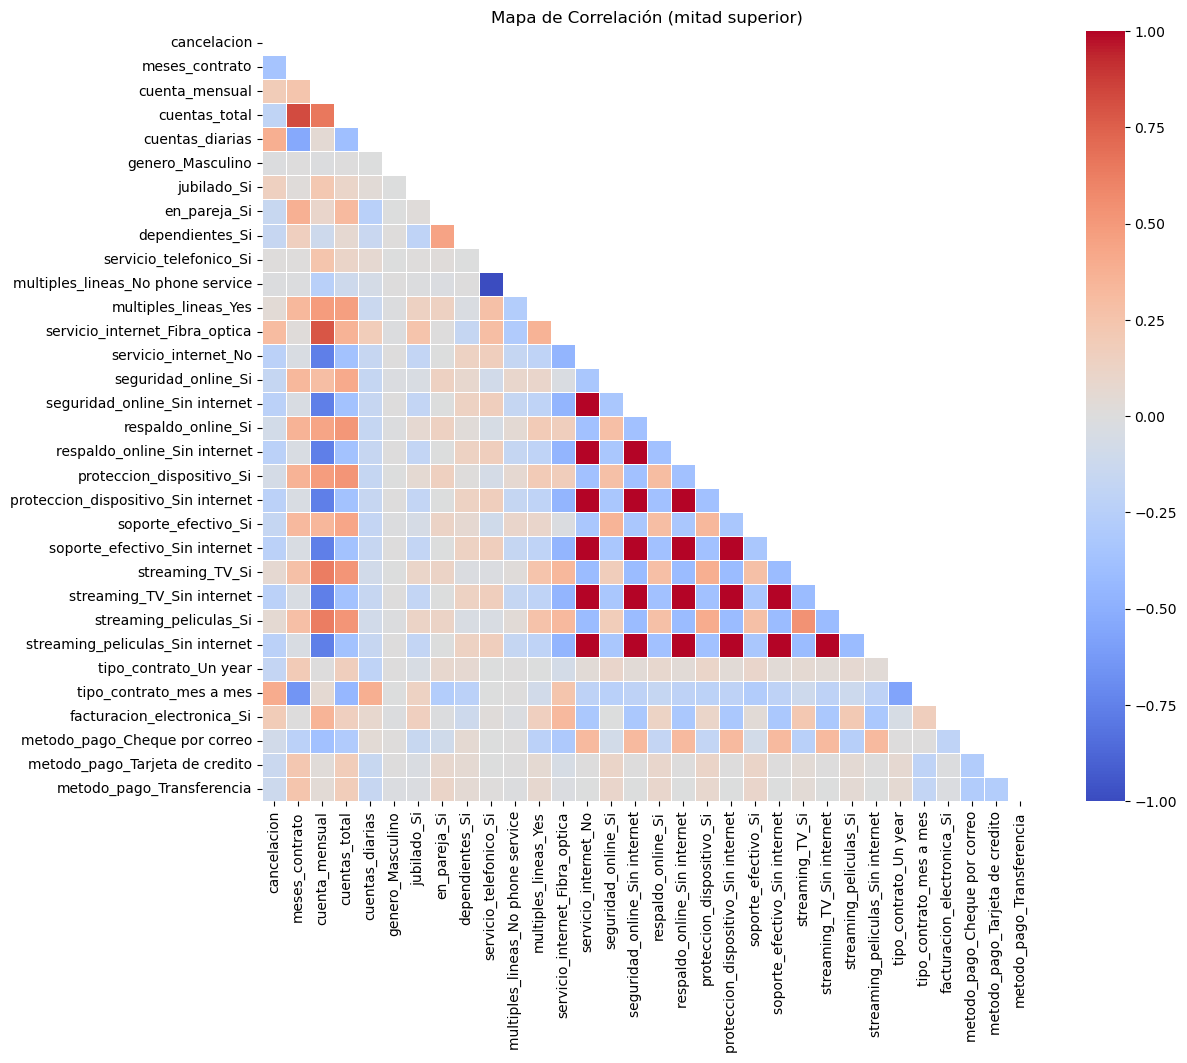

In [101]:
# codificamos las variables categoricas
df_encoded = pd.get_dummies(df_exp, drop_first=True)
# calculamos la matriz de correlacion
corr_matrix = df_encoded.corr()

# evita mostrar duplicado en la matriz de correlacion
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# graficamos matriz de correlacion
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Mapa de Correlación (mitad superior)')
# guardar grafico
plt.savefig('./data_out/heatmap_corr.png', dpi=300, bbox_inches='tight')
plt.show()

> El heatmap muestra que la variable objetivo 'cancelacion' presenta cierta correlacion directa con las variables 'tipo_contrato mes a mes', 'facturacion_electronica_Si', 'servicio_internet_Fibra_Optica', 'cuentas_total' y 'cuenta_mensual'.

> Tambien muestra que la variable 'cancelacion' esta inversamente correlacionada con la variable 'meses_contrato'.

En lo que sigue, vamos a analizar a fondo cada una de estas variables y probar las hipotesis obtenidas del analisis descriptivo.

### 1.- Proporcion de clientes que cancelan y no cancelan

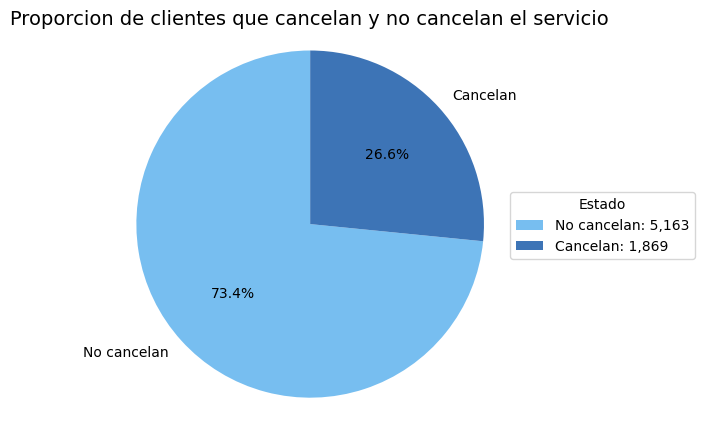

In [102]:
# obtener cantidad de clientes que cancelan y no cancelan
cancelacion = df_exp['cancelacion'].value_counts()

# definir etiquetas
etiquetas = ['No cancelan', 'Cancelan']

# definir colores para cada clase
color = ['#77BEF0', '#3D74B6']

# grafico circular
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(
    cancelacion,
    autopct='%1.1f%%',
    startangle=90,
    labels=etiquetas,
    colors=color
    )

# agregar porcentajes al grafico
valores_abs = [f'{etiqueta}: {valor:,}' for etiqueta, valor in zip(etiquetas, cancelacion)]
ax.legend(valores_abs, title='Estado', loc='center left', bbox_to_anchor=(1, 0.5))

# personalizacion del grafico
plt.title('Proporcion de clientes que cancelan y no cancelan el servicio', fontsize=14)
ax.axis('equal')
# guardar grafico
plt.savefig('./data_out/prop_clientes.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.- Clientes que cancelan basados en el tiempo de permanencia

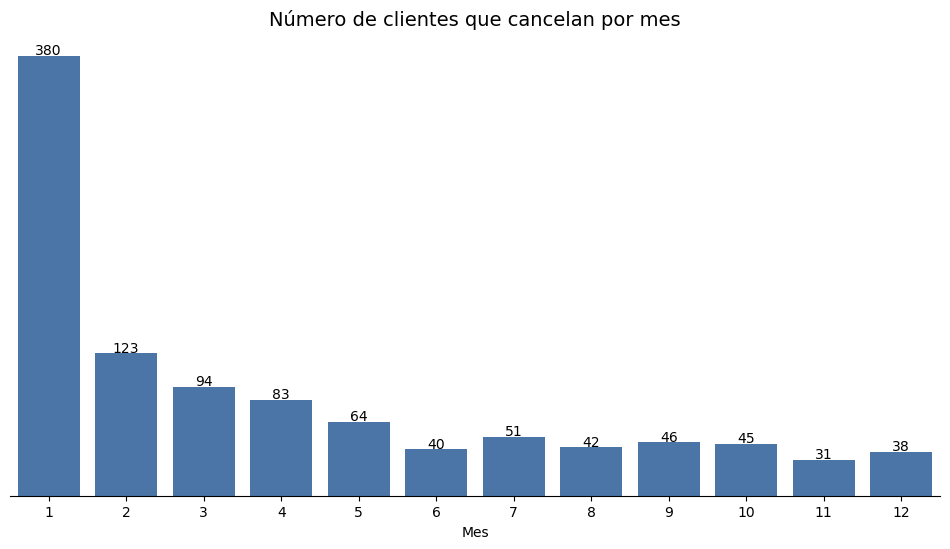

In [103]:
import seaborn as sns

# filtrar clientes que cancelaron el servicio y que tienen menos de 12 meses de contrato
filtro = df_exp[(df_exp['cancelacion'] == 1) & (df_exp['meses_contrato'] <= 12)]

# contar clientes que cancelan para cada mes
df_cancelan_meses = filtro['meses_contrato'].value_counts().reset_index()
df_cancelan_meses = df_cancelan_meses.sort_values(by='meses_contrato')
df_cancelan_meses

# grafico de barra
plt.figure(figsize=(12, 6))
sns.barplot(data=df_cancelan_meses, x='meses_contrato', y='count', color='#3D74B6')
sns.despine(top=True, right=True, left=True)

# agregar valores sobre cada columna
for i, v in enumerate(df_cancelan_meses['count']):
    plt.text(i, v+1, str(v), ha='center', color='black', fontsize=10)

# personalizacion grafico
plt.title('Número de clientes que cancelan por mes', fontsize=14)
plt.xlabel('Mes', fontsize=10)
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([])

# guardar grafico
plt.savefig('./data_out/cancelacion_mes.png', dpi=300, bbox_inches='tight')
plt.show()

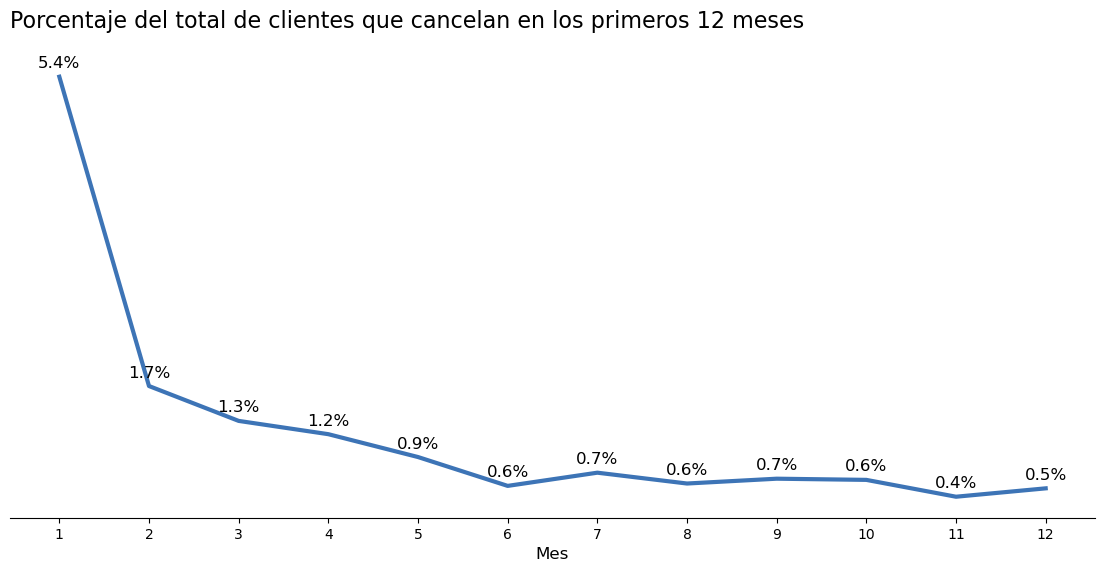

In [104]:
# obtener los meses de contrato de los clientes que cancelan
pct_cancelan_meses = df_exp[(df_exp['cancelacion'] == 1)]['meses_contrato'].value_counts().reset_index()
# crear nueva columna con el porcentaje por mes del total de clientes
pct_cancelan_meses['pct_total'] = round((pct_cancelan_meses['count']/7032)*100, 3)
# ordenar dataframe por la cantidad de meses
pct_cancelan_meses = pct_cancelan_meses.sort_values(by='meses_contrato')
# seleccionar los primeros 12 meses
pct_cancelan_meses = pct_cancelan_meses[:12]


# Crear grafico de linea
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(
    pct_cancelan_meses['meses_contrato'].values,
    pct_cancelan_meses['pct_total'].values,
    color='#3D74B6',
    lw=3
)

# Añadimos porcentajes al graico
for x, y in zip(pct_cancelan_meses['meses_contrato'], pct_cancelan_meses['pct_total']):
    plt.text(
        x, y + 0.1,               # Ligeramente encima del punto
        f"{y:.1f}%",               # Formato con un decimal
        ha='center',
        color='black',
        fontsize=12
    )

# persoalizar grafico
ax.set_title('Porcentaje del total de clientes que cancelan en los primeros 12 meses',loc='left',fontsize=16,pad=20)
ax.set_xlabel('Mes',fontsize=12)
# quitar lineas del grafico segun su posicion
sns.despine(top=True, right=True, left=True)
# Establecer ticks de 1 al 12 en el eje X
ax.set_xticks(range(1, 13))
ax.set_xticklabels(range(1, 13))
# Quita completamente los ticks y sus etiquetas
ax.set_yticks([])        

# guardar grafico
plt.savefig('./data_out/cancelacion_total_mes.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.- Distribucion del cargo mensual segun la permanencia de los clientes

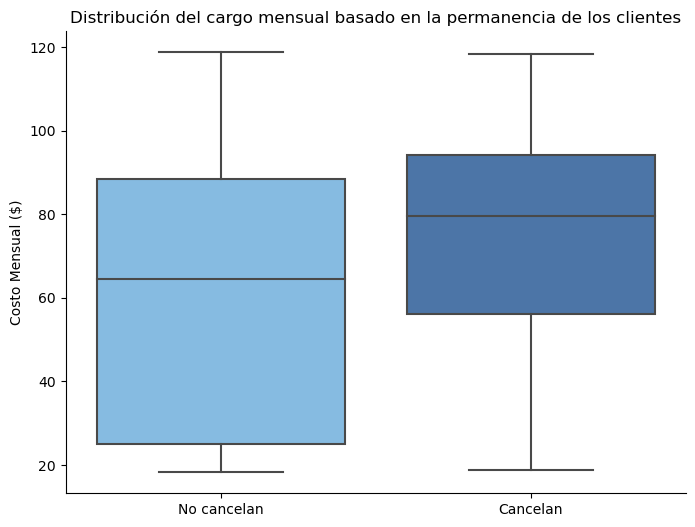

In [105]:
# definir colores para cada clase
color = ['#77BEF0', '#3D74B6']

# Crear grafico boxpplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='cancelacion', y='cuenta_mensual', data=df_exp, palette=color)

# personalizar grafico
plt.title('Distribución del cargo mensual basado en la permanencia de los clientes', fontsize=12)
plt.xlabel('')
plt.ylabel('Costo Mensual ($)')
ax.set_xticklabels(['No cancelan', 'Cancelan'])

# quitar lineas del grafico segun su posicion
sns.despine(top=True, right=True)

# guardar grafico
plt.savefig('./data_out/dist_cargo_mensual.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.- Distribucion del cargo total basado en la permanencia de los clientes

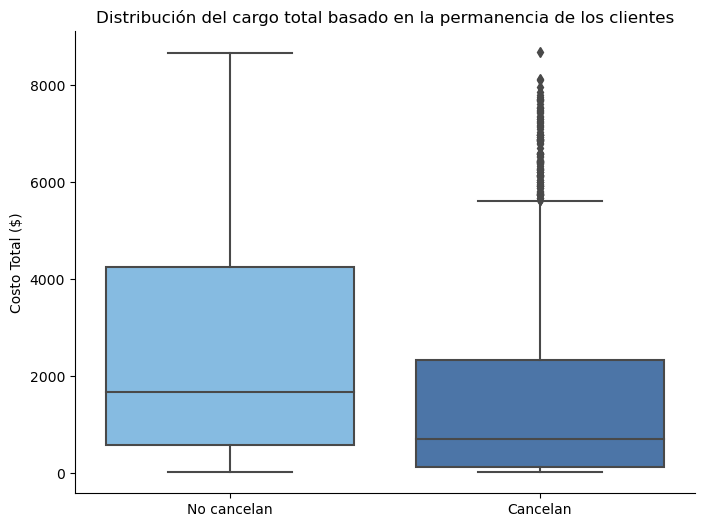

In [106]:
# definir colores para cada clase
color = ['#77BEF0', '#3D74B6']

# Crear grafico boxpplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='cancelacion', y='cuentas_total', data=df_exp, palette=color)

# personalizar grafico
plt.title('Distribución del cargo total basado en la permanencia de los clientes', fontsize=12)
plt.xlabel('')
plt.ylabel('Costo Total ($)')
ax.set_xticklabels(['No cancelan', 'Cancelan'])

# quitar lineas del grafico segun su posicion
sns.despine(top=True, right=True)

# guardar grafico
plt.savefig('./data_out/dist_cargo_total.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.- Analisis de la permanencia del cliente en funcion del servicio de internet.

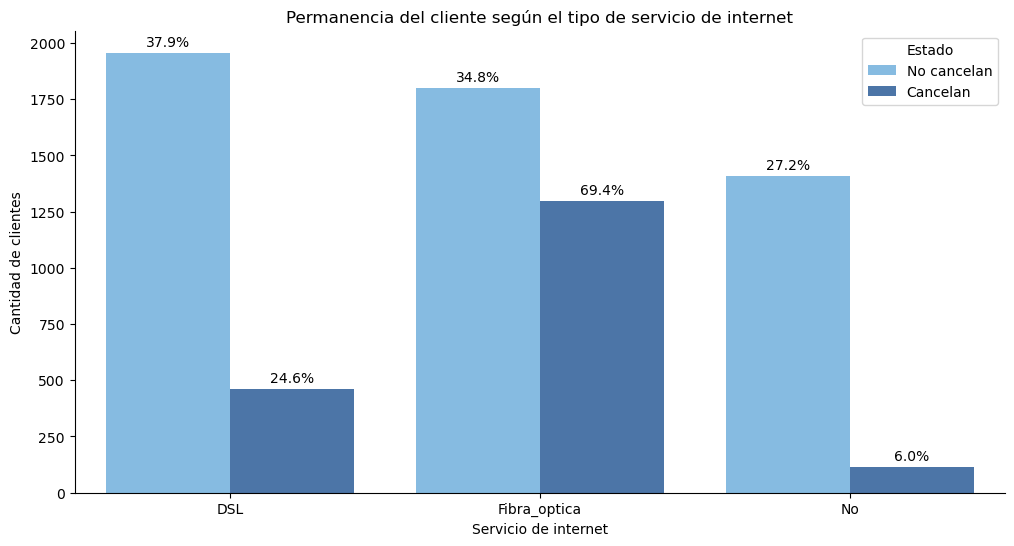

In [107]:
# Calcular proporciones
proporciones = []
for cancelacion_val in [0, 1]:
    subset = df_exp[df_exp['cancelacion'] == cancelacion_val]
    proporciones.extend((subset['servicio_internet'].value_counts(normalize=True) * 100).tolist())

# ordenar porcentajes de acuerdo a la posicion de las barras
proporciones = [37.90, 34.84, 27.25, 24.55, 69.39, 6.04]

# definir colores para cada clase
color = ['#77BEF0', '#3D74B6']

# Grafico de barra
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_exp, x='servicio_internet', hue='cancelacion', palette=color)
sns.despine(top=True, right=True)

# Cambiar nombres de la leyenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No cancelan', 'Cancelan'], title='Estado')

# Agregar porcentajes sobre las barras 
for p, porcentaje in zip(ax.patches, proporciones):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 30, f"{porcentaje:.1f}%", ha='center', fontsize=10)

# personalizar grafico
plt.title('Permanencia del cliente según el tipo de servicio de internet', fontsize=12)
plt.xlabel('Servicio de internet')
plt.ylabel('Cantidad de clientes')

# guardar grafico
plt.savefig('./data_out/permanencia_internet.png', dpi=300, bbox_inches='tight')
plt.show()


### 6.- Analisis de la permanencia del cliente en funcion del tipo de contrato

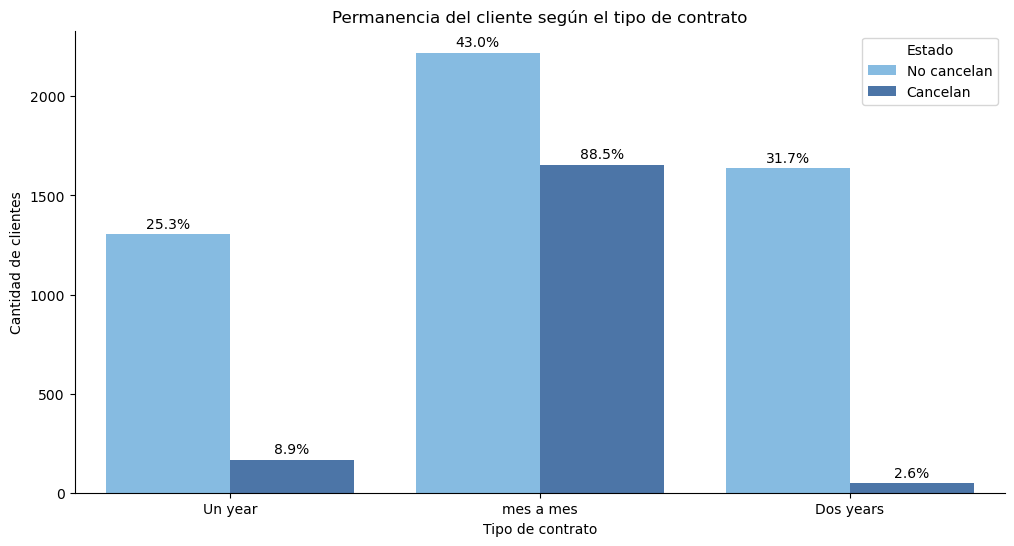

In [108]:
# Calcular proporciones
proporciones = []
for cancelacion_val in [0, 1]:
    subset = df_exp[df_exp['cancelacion'] == cancelacion_val]
    proporciones.extend((subset['tipo_contrato'].value_counts(normalize=True) * 100).tolist())

# ordenar porcentajes de acuerdo a la posicion de las barras
proporciones = [25.29, 42.99, 31.70, 8.88, 88.55, 2.56]

# definir colores para cada clase
color = ['#77BEF0', '#3D74B6']

# Grafico de barra
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_exp, x='tipo_contrato', hue='cancelacion', palette=color)
sns.despine(top=True, right=True)

# Cambiar nombres de la leyenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No cancelan', 'Cancelan'], title='Estado')

# Agregar porcentajes sobre las barras 
for p, porcentaje in zip(ax.patches, proporciones):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 30, f"{porcentaje:.1f}%", ha='center', fontsize=10)

# personalizar grafico
plt.title('Permanencia del cliente según el tipo de contrato', fontsize=12)
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')

# guardar grafico
plt.savefig('./data_out/permanencia_tipo_contrato.png', dpi=300, bbox_inches='tight')
plt.show()


### 7.- Analisis de permanencia de clientes en funcion de la facturacion electronica

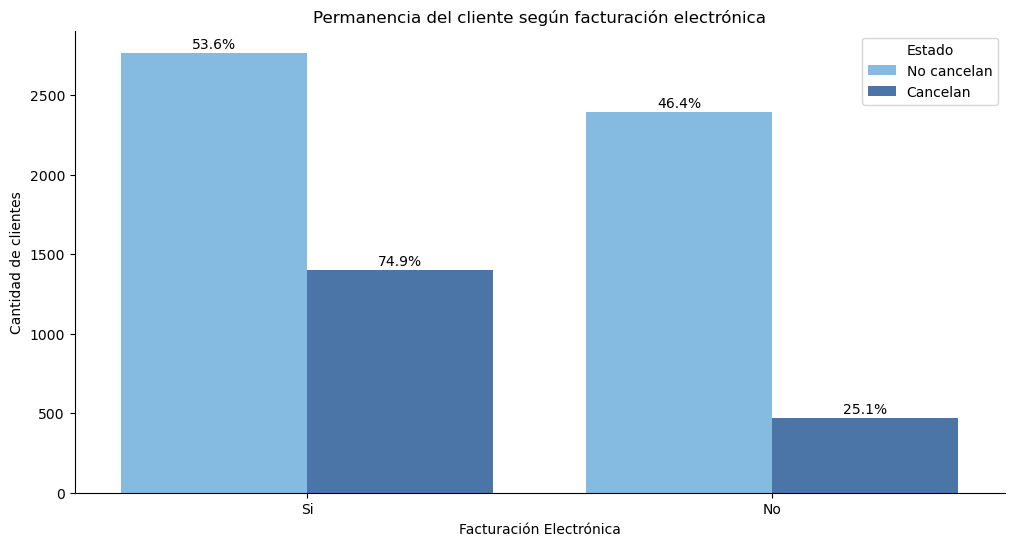

In [109]:
# Calcular proporciones
proporciones = []
for cancelacion_val in [0, 1]:
    subset = df_exp[df_exp['cancelacion'] == cancelacion_val]
    proporciones.extend((subset['facturacion_electronica'].value_counts(normalize=True) * 100).tolist())

# ordenar porcentajes de acuerdo a la posicion de las barras
proporciones = [53.61, 46.38, 74.90, 25.09]

# definir colores para cada clase
color = ['#77BEF0', '#3D74B6']

# Grafico de barra
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_exp, x='facturacion_electronica', hue='cancelacion', palette=color)
sns.despine(top=True, right=True)

# Cambiar nombres de la leyenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No cancelan', 'Cancelan'], title='Estado')

# Agregar porcentajes sobre las barras 
for p, porcentaje in zip(ax.patches, proporciones):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 30, f"{porcentaje:.1f}%", ha='center', fontsize=10)

# personalizar grafico
plt.title('Permanencia del cliente según facturación electrónica', fontsize=12)
plt.xlabel('Facturación Electrónica')
plt.ylabel('Cantidad de clientes')

# guardar grafico
plt.savefig('./data_out/permanencia_facturacion_electronica.png', dpi=300, bbox_inches='tight')
plt.show()


## Conclusiones

A partir del analisis estadistico inicial tanto para los clientes que cancelan y mantienen el servicio deducimos que el Genero no tiene influencia sobre la permanencia de los clientes en la empresa

---

La proporcion de clientes que permanecen con el servicio es casi 3 veces mayor que la proporcion de clientes que cancelan, lo cual podria crear un sesgo al analizar todo el conjunto de datos.

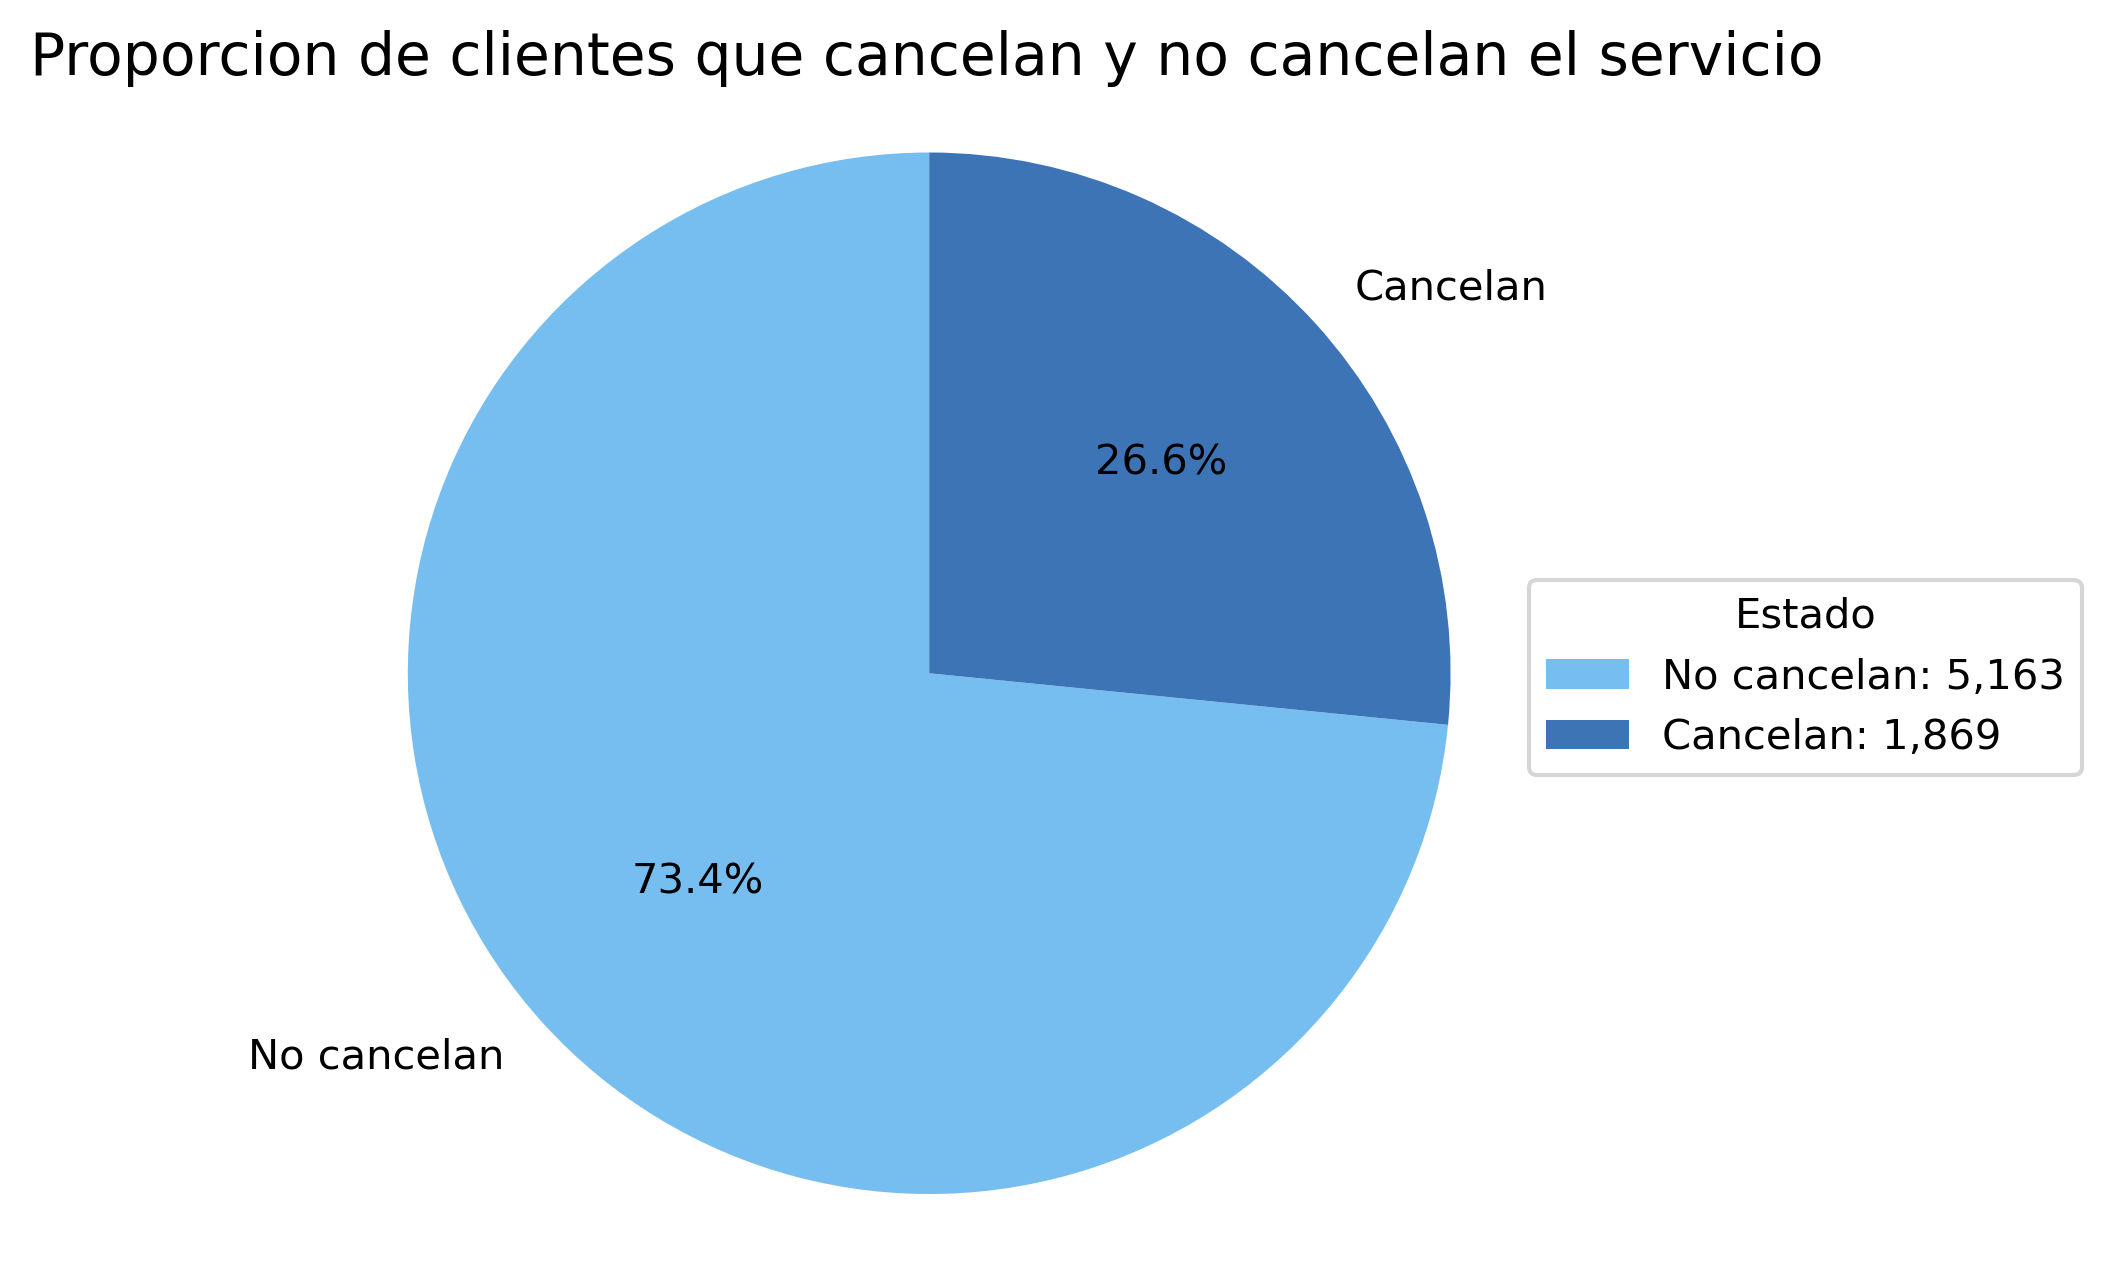

In [110]:
Image('./data_out/prop_clientes.png',width=600)

---

Un porcentaje pequeno pero considerable de clientes (5.4%) cancelan el servicio en el primer mes. En el mes 6, alrededor del 11% de los clientes finalizan el servicio. Tales resultados nos sugieren que debemos revisar lo que esta ocurriendo en los primeros tanto en los servicios que se brindan como en las caracteristicas de los clientes.


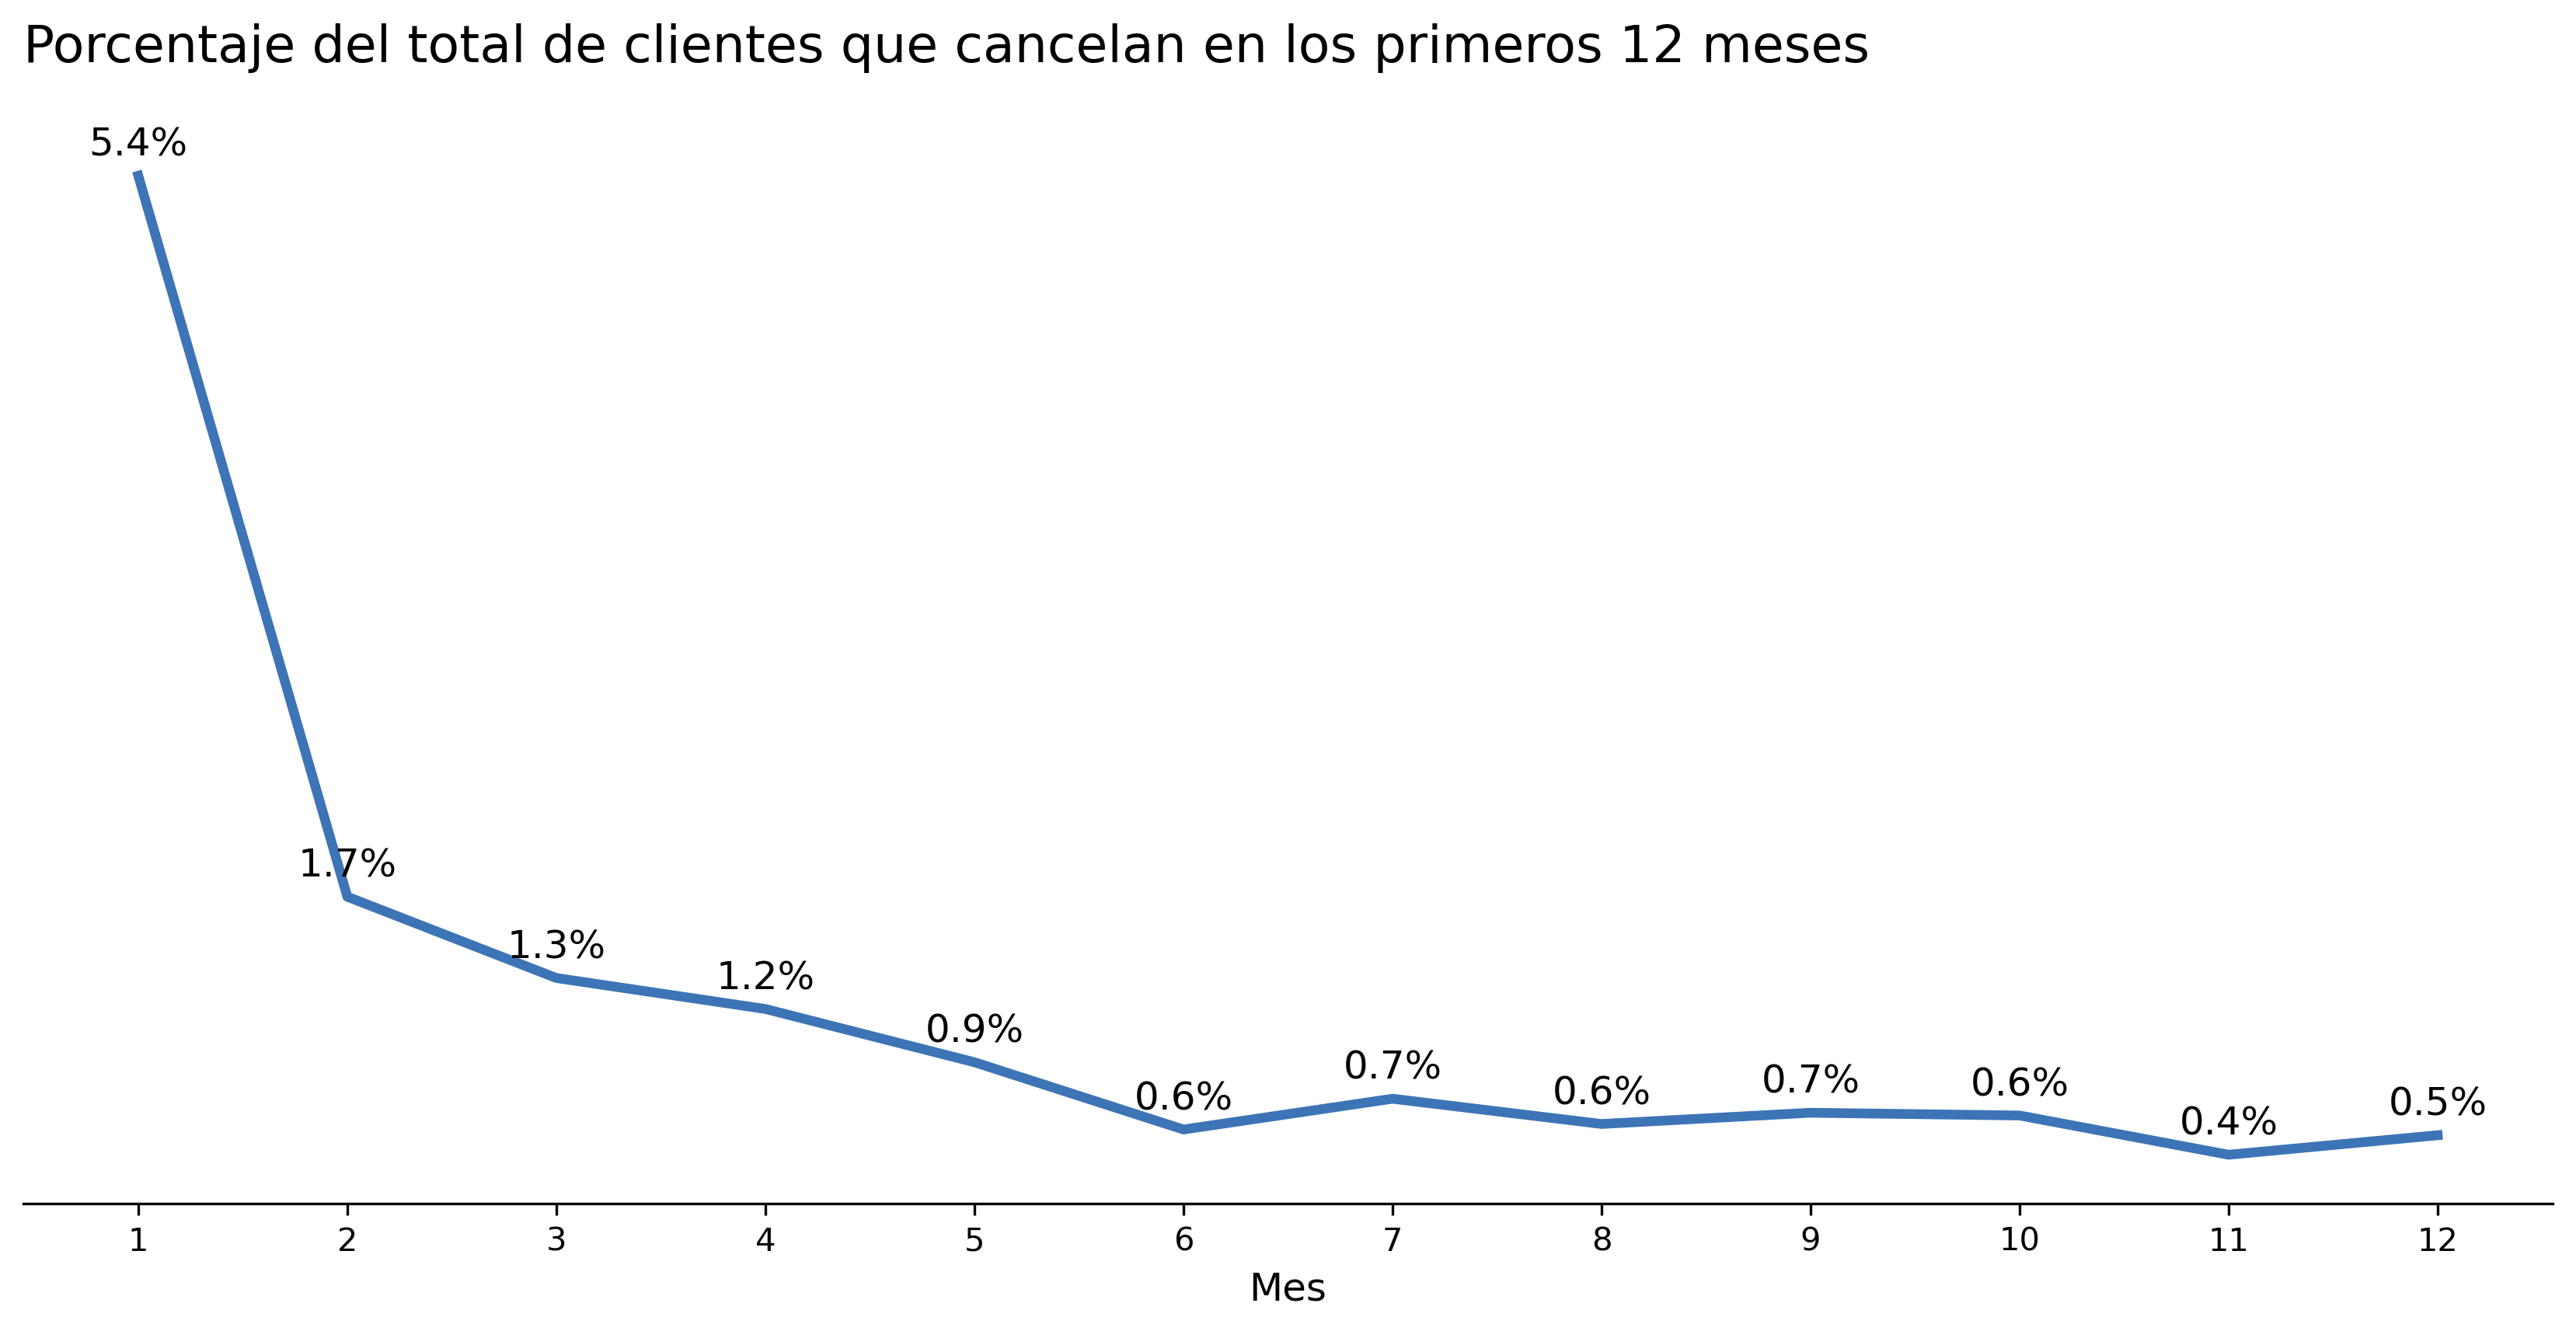

In [111]:
Image('./data_out/cancelacion_total_mes.png', width=600)

---

Una de las posibles razones por las cuales los clientes cancelan podria ser el alto cargo mensual que pagan a la empresa por los diferentes servicios que contratan.  

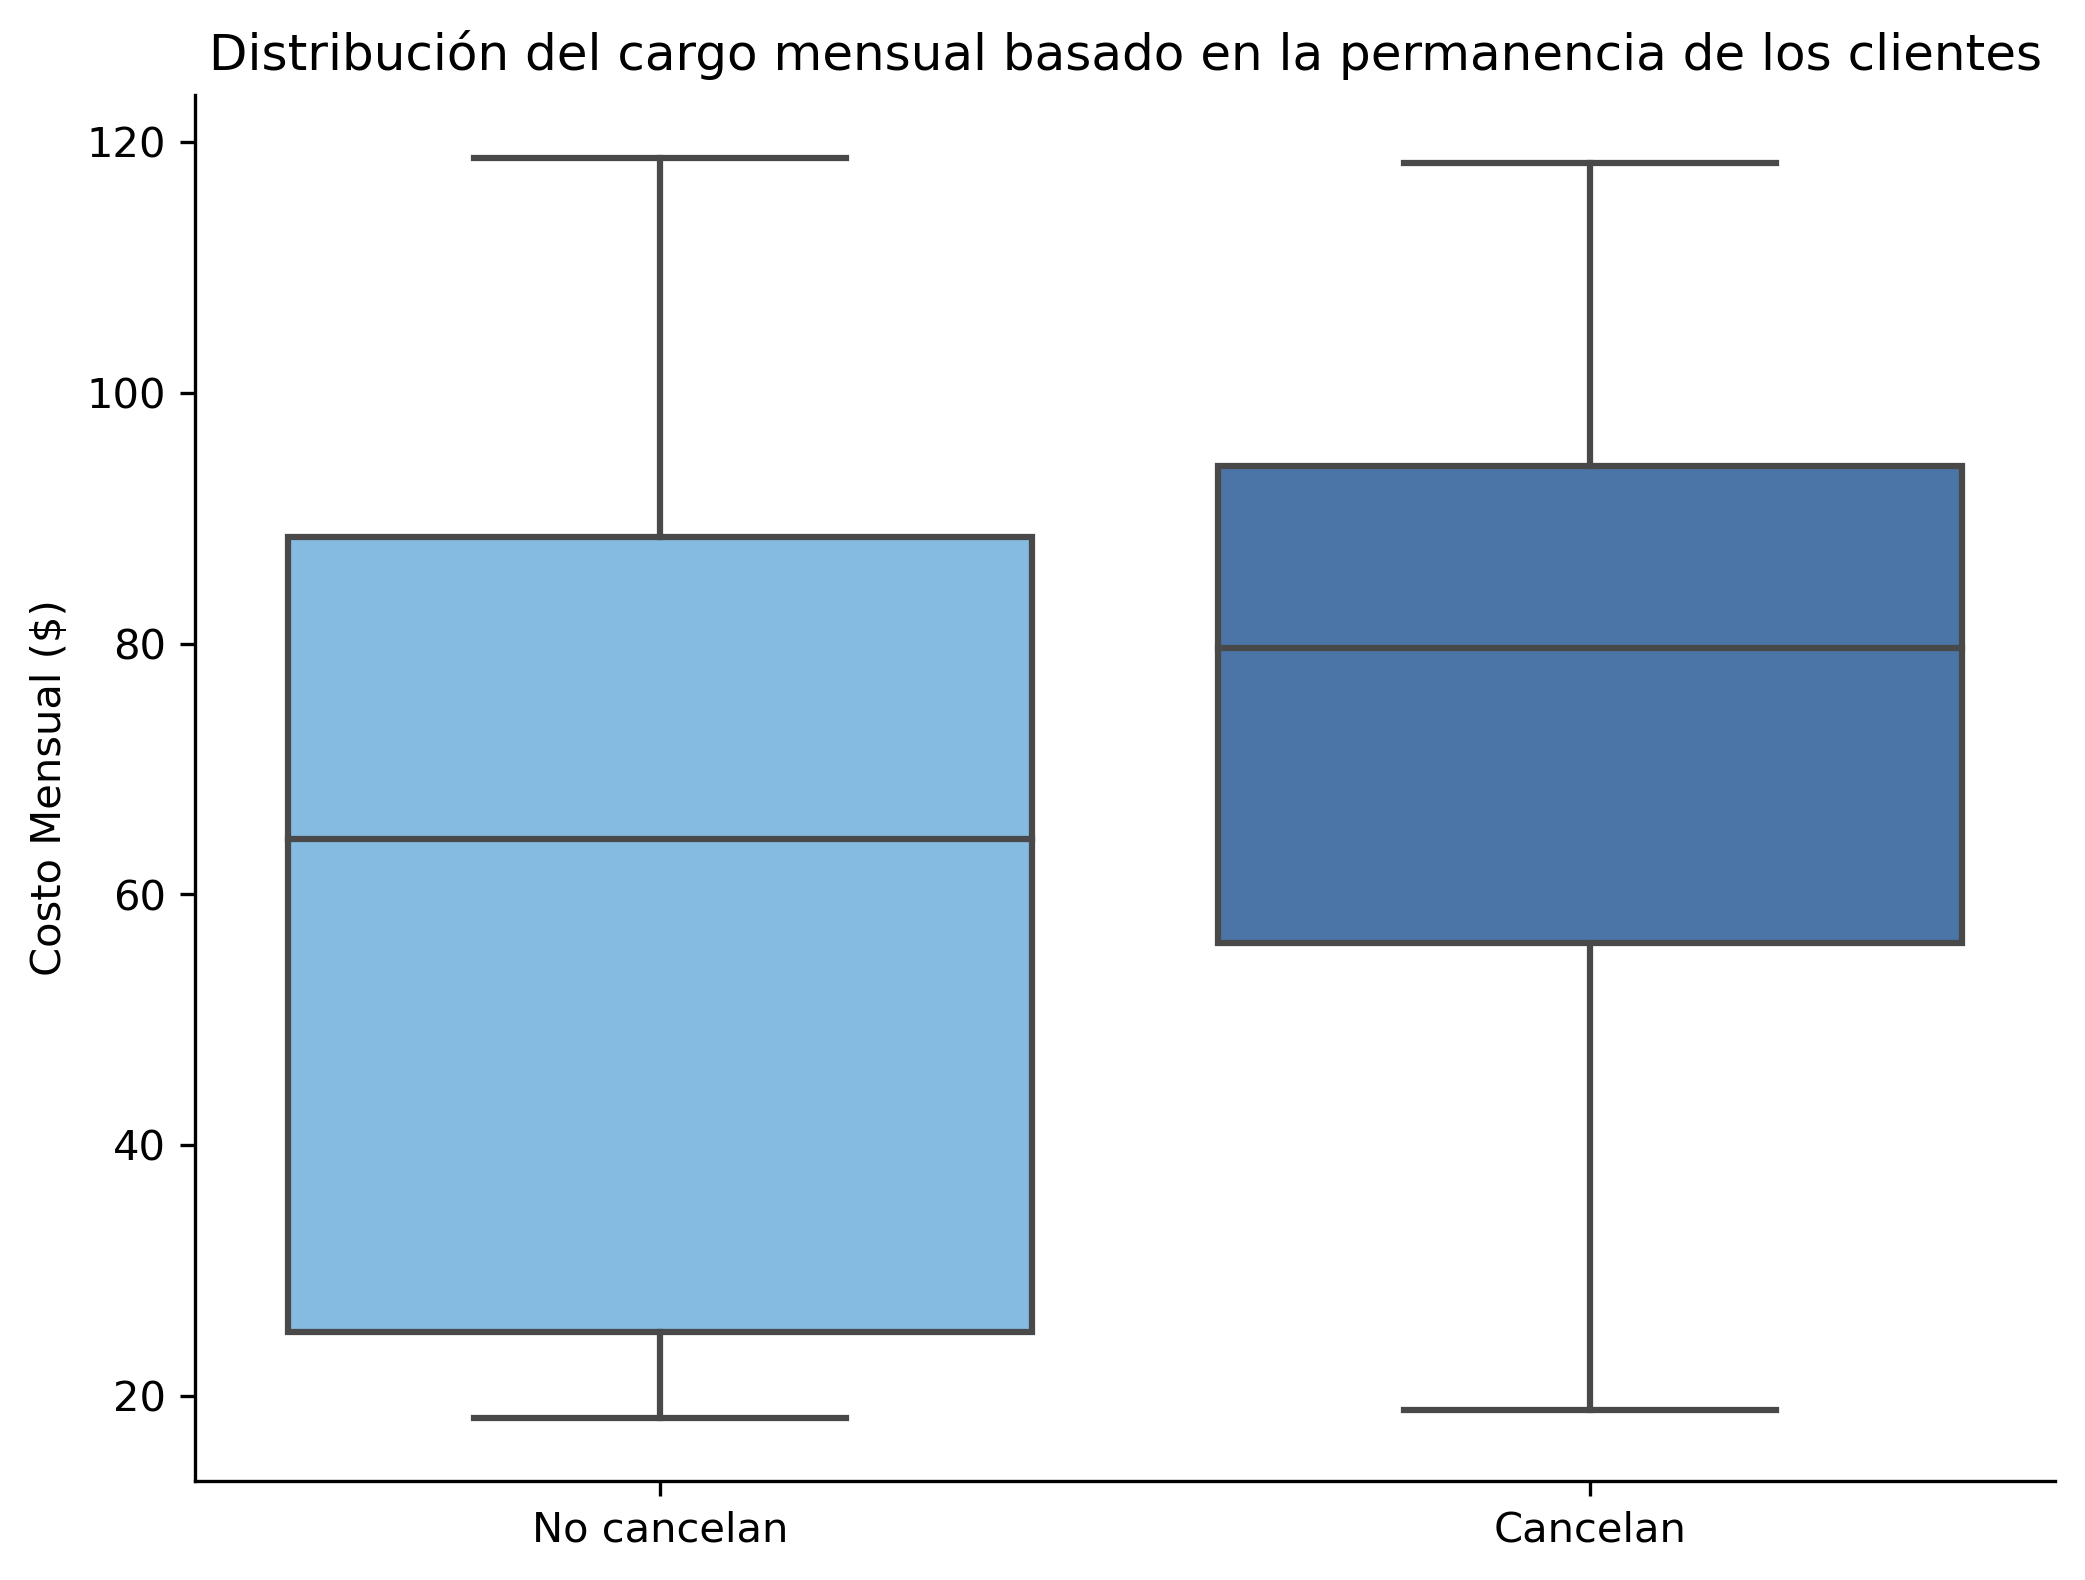

In [112]:
Image('./data_out/dist_cargo_mensual.png', width=600)

---

Los clientes que permanecen con la empresa, tienen un gasto total mayor que los que cancelan. Este comportamiento es logico debido a que los clientes con mayor tiempo son los que mayor gastos adquieren y lo que aun permanecen con la misma 

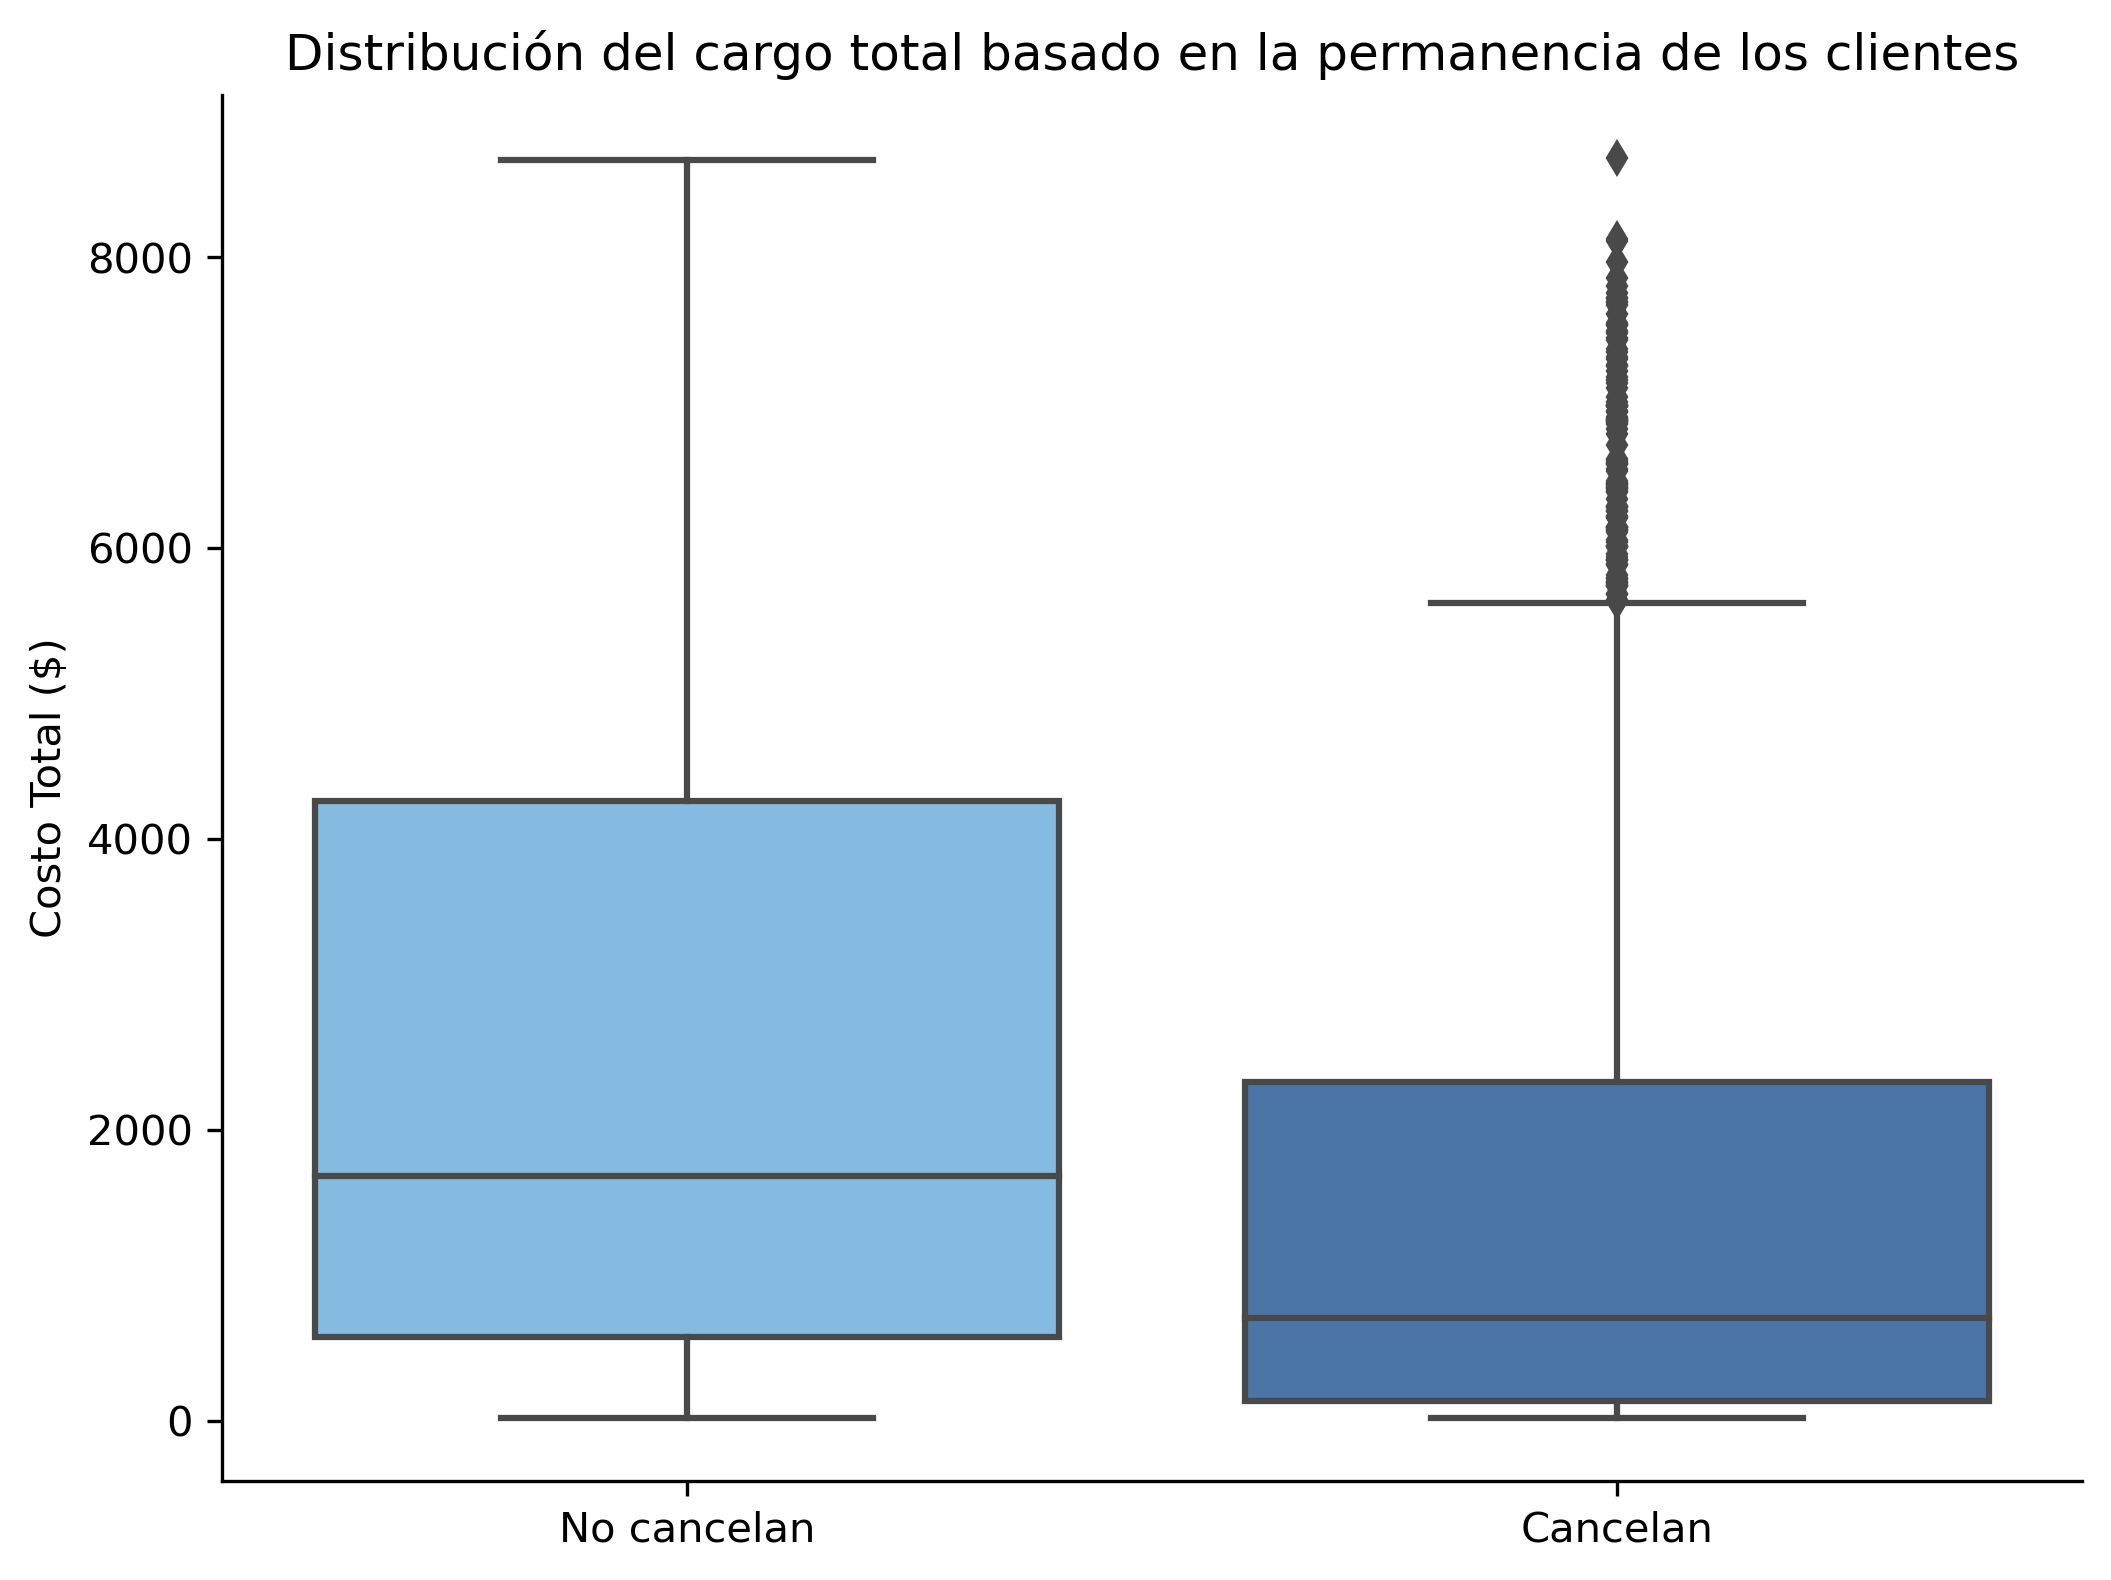

In [113]:
Image('./data_out/dist_cargo_total.png', width=600)

---

Una gran parte de los clientes que se mantienen con la empresa tienen un servicio DSL de internet, mientras que el resto, en proporciones cercanas adquieren un servicio de fibra optica y otros no tienen internet.

Se evidencia que la mayoria de los clientes que cancelan el servicio tenian Fibra optica. Podria haber un problema en este servicio que hace que los clientes abandonen la empresa.

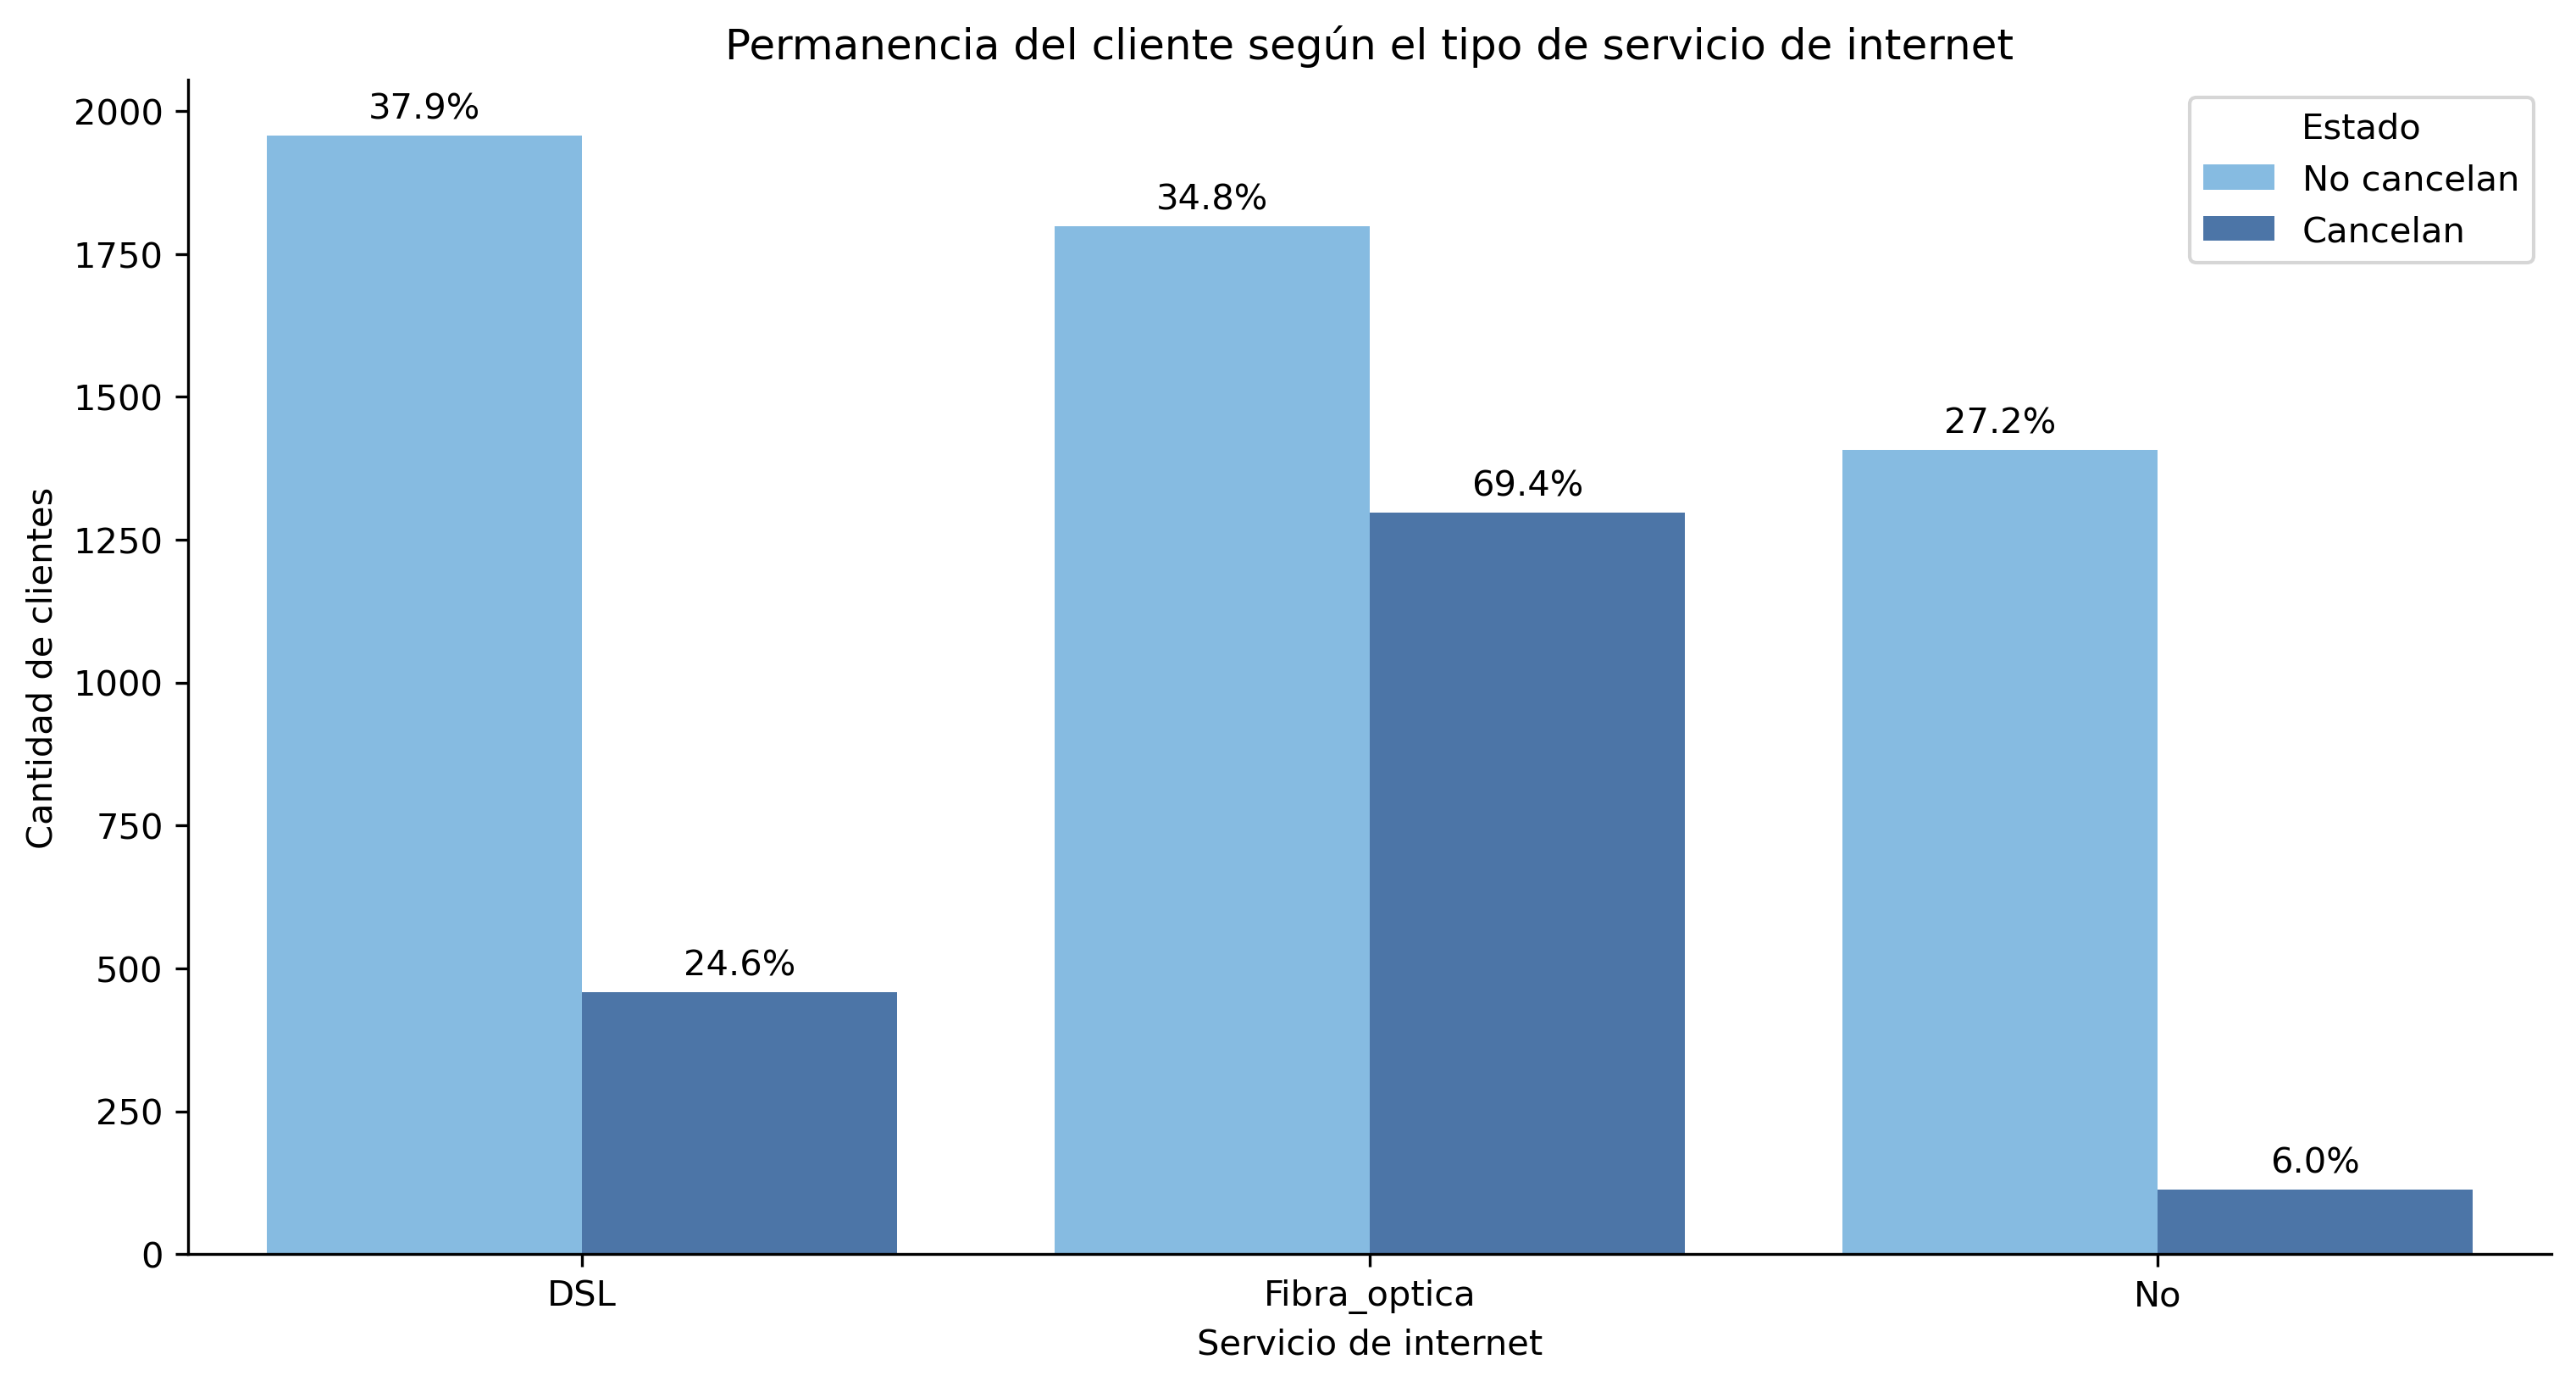

In [114]:
Image('./data_out/permanencia_internet.png', width=600)

---

Podria haber una tendencia de los clientes que cancelan el servicio con recibir factura electronica. El 75% que la reciben, cancelan el servicio. Debe revisarse la forma en que llega la factura a los clientes, incluso cambiar de estrategia haciendoles llegar factura fisica. 


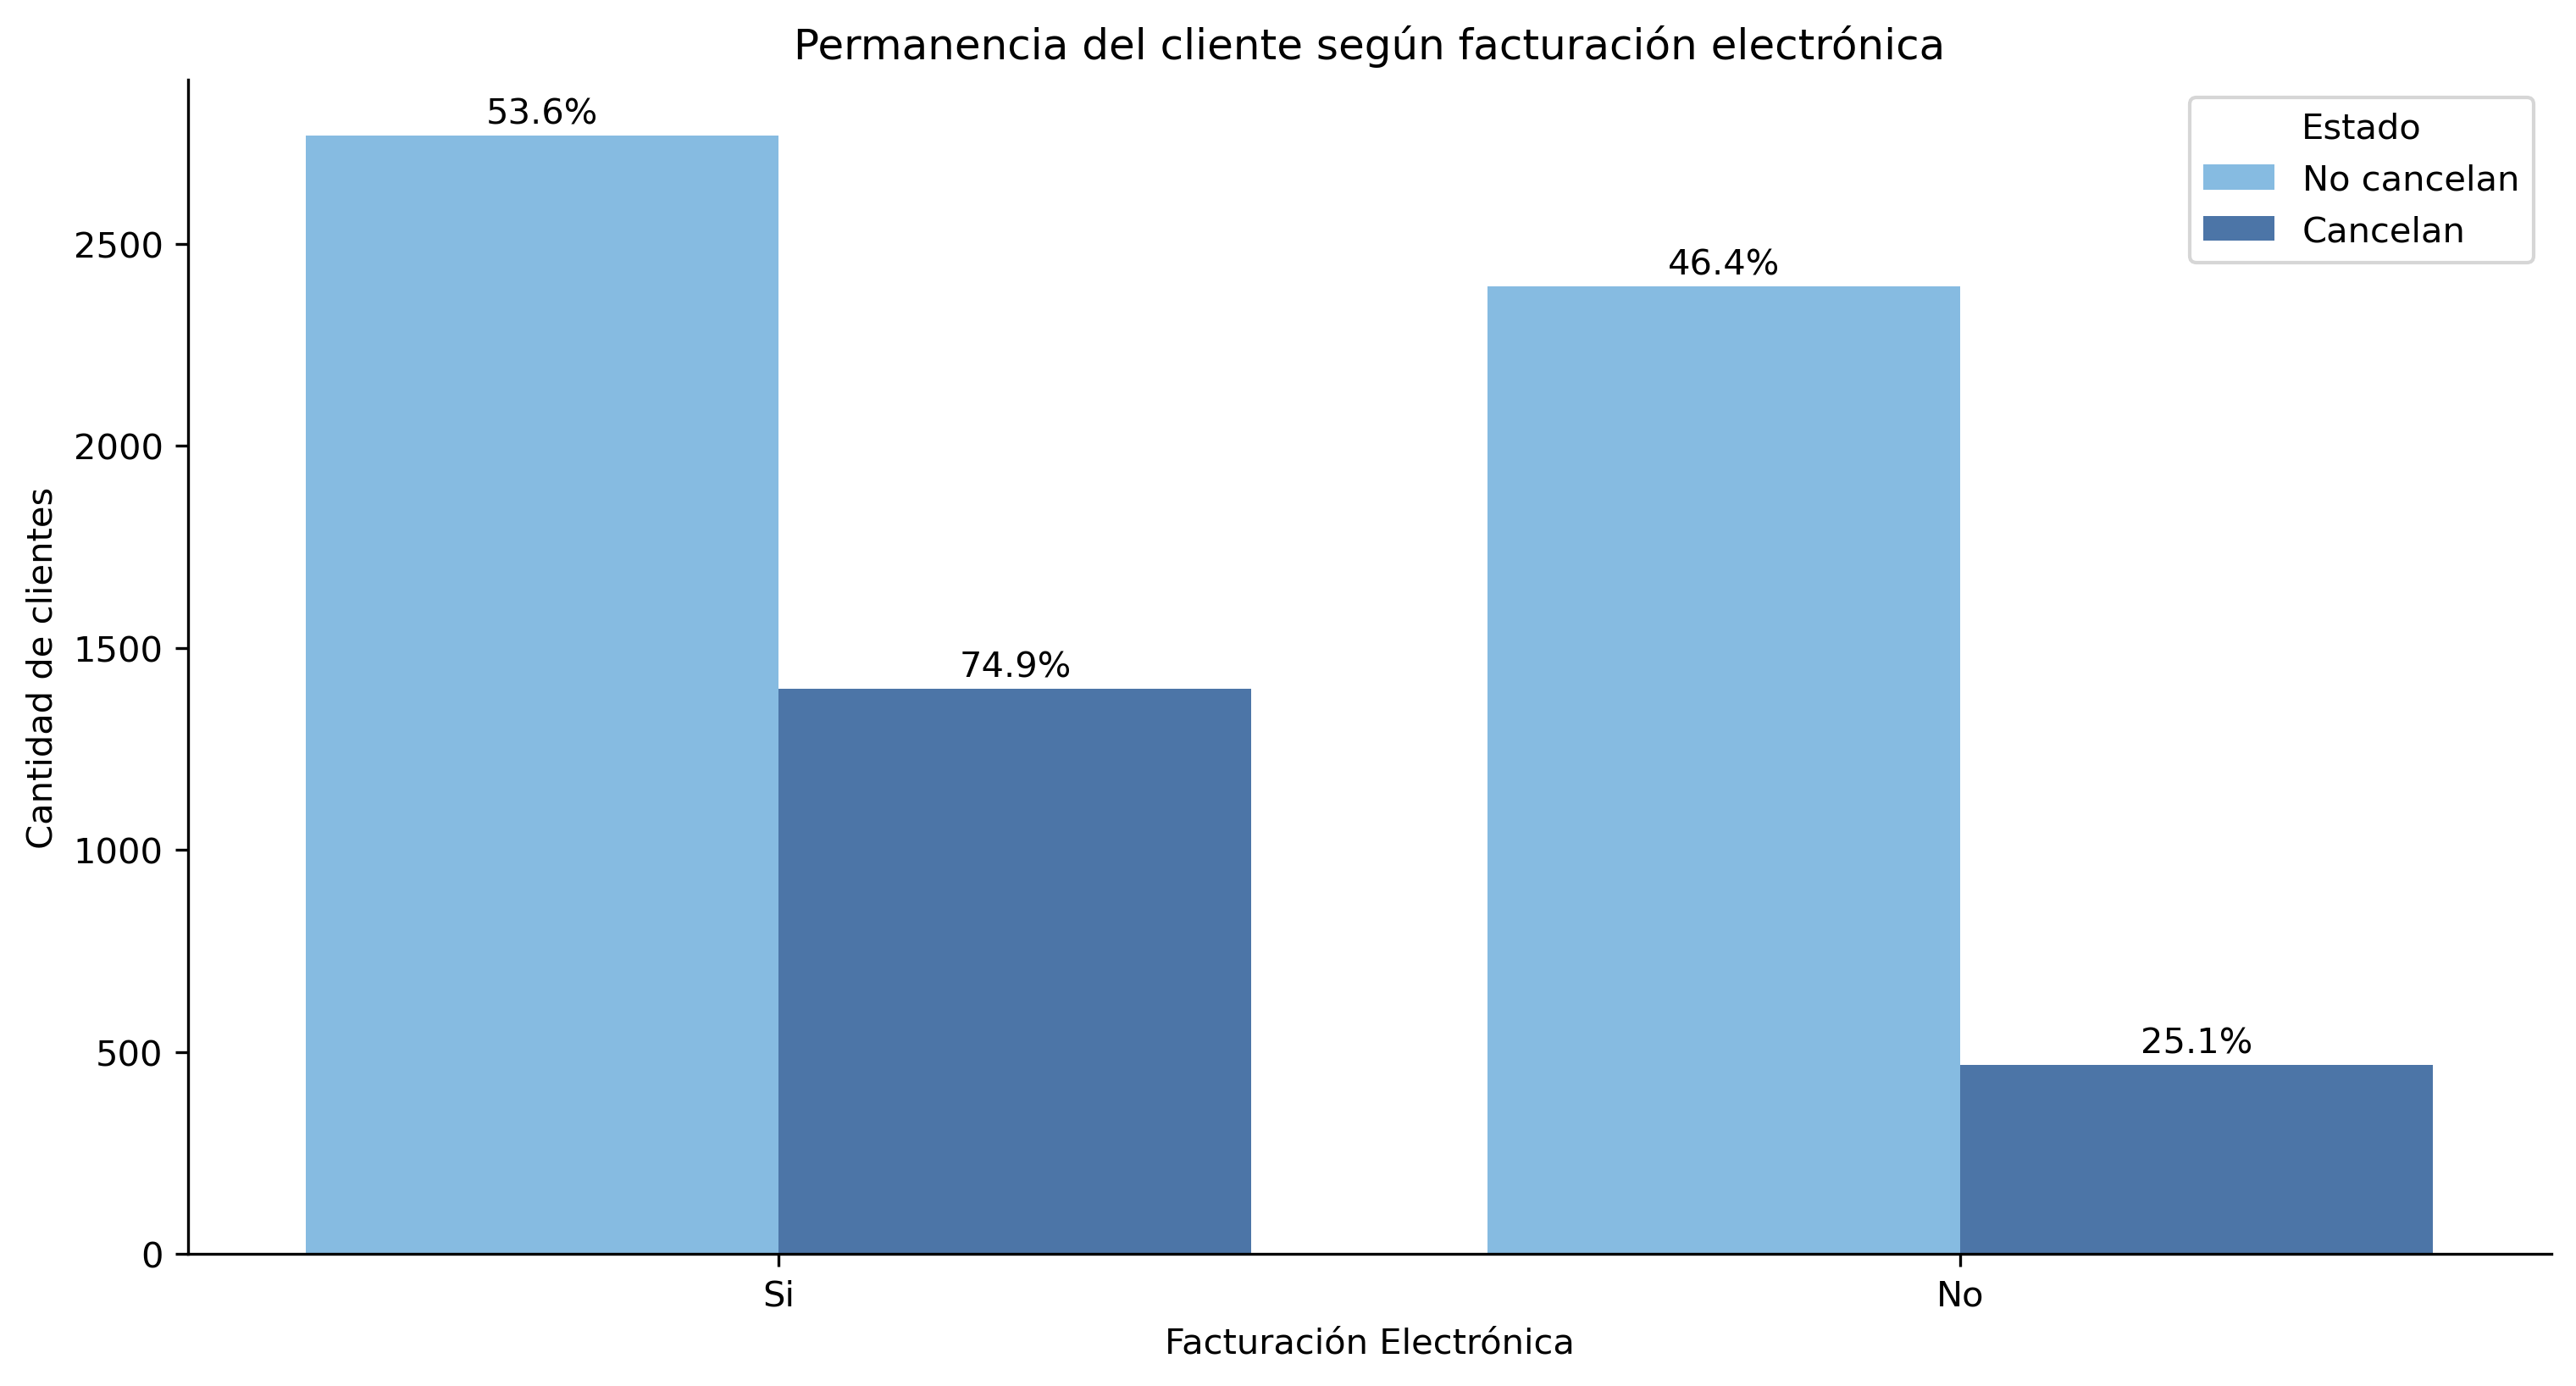

In [115]:
Image('./data_out/permanencia_facturacion_electronica.png', width=600)

---

La mayoria de los clientes que cancelan tienen preferencia por el tipo de contrato mes a mes. Esto puede deberse a que solo quieren probar el servicio y al final terminan insatisfechos. Esto evidencia un problema en el servicio de la empresa que debe corregirse especialmente en los primeros meses de uso por parte de los clientes.

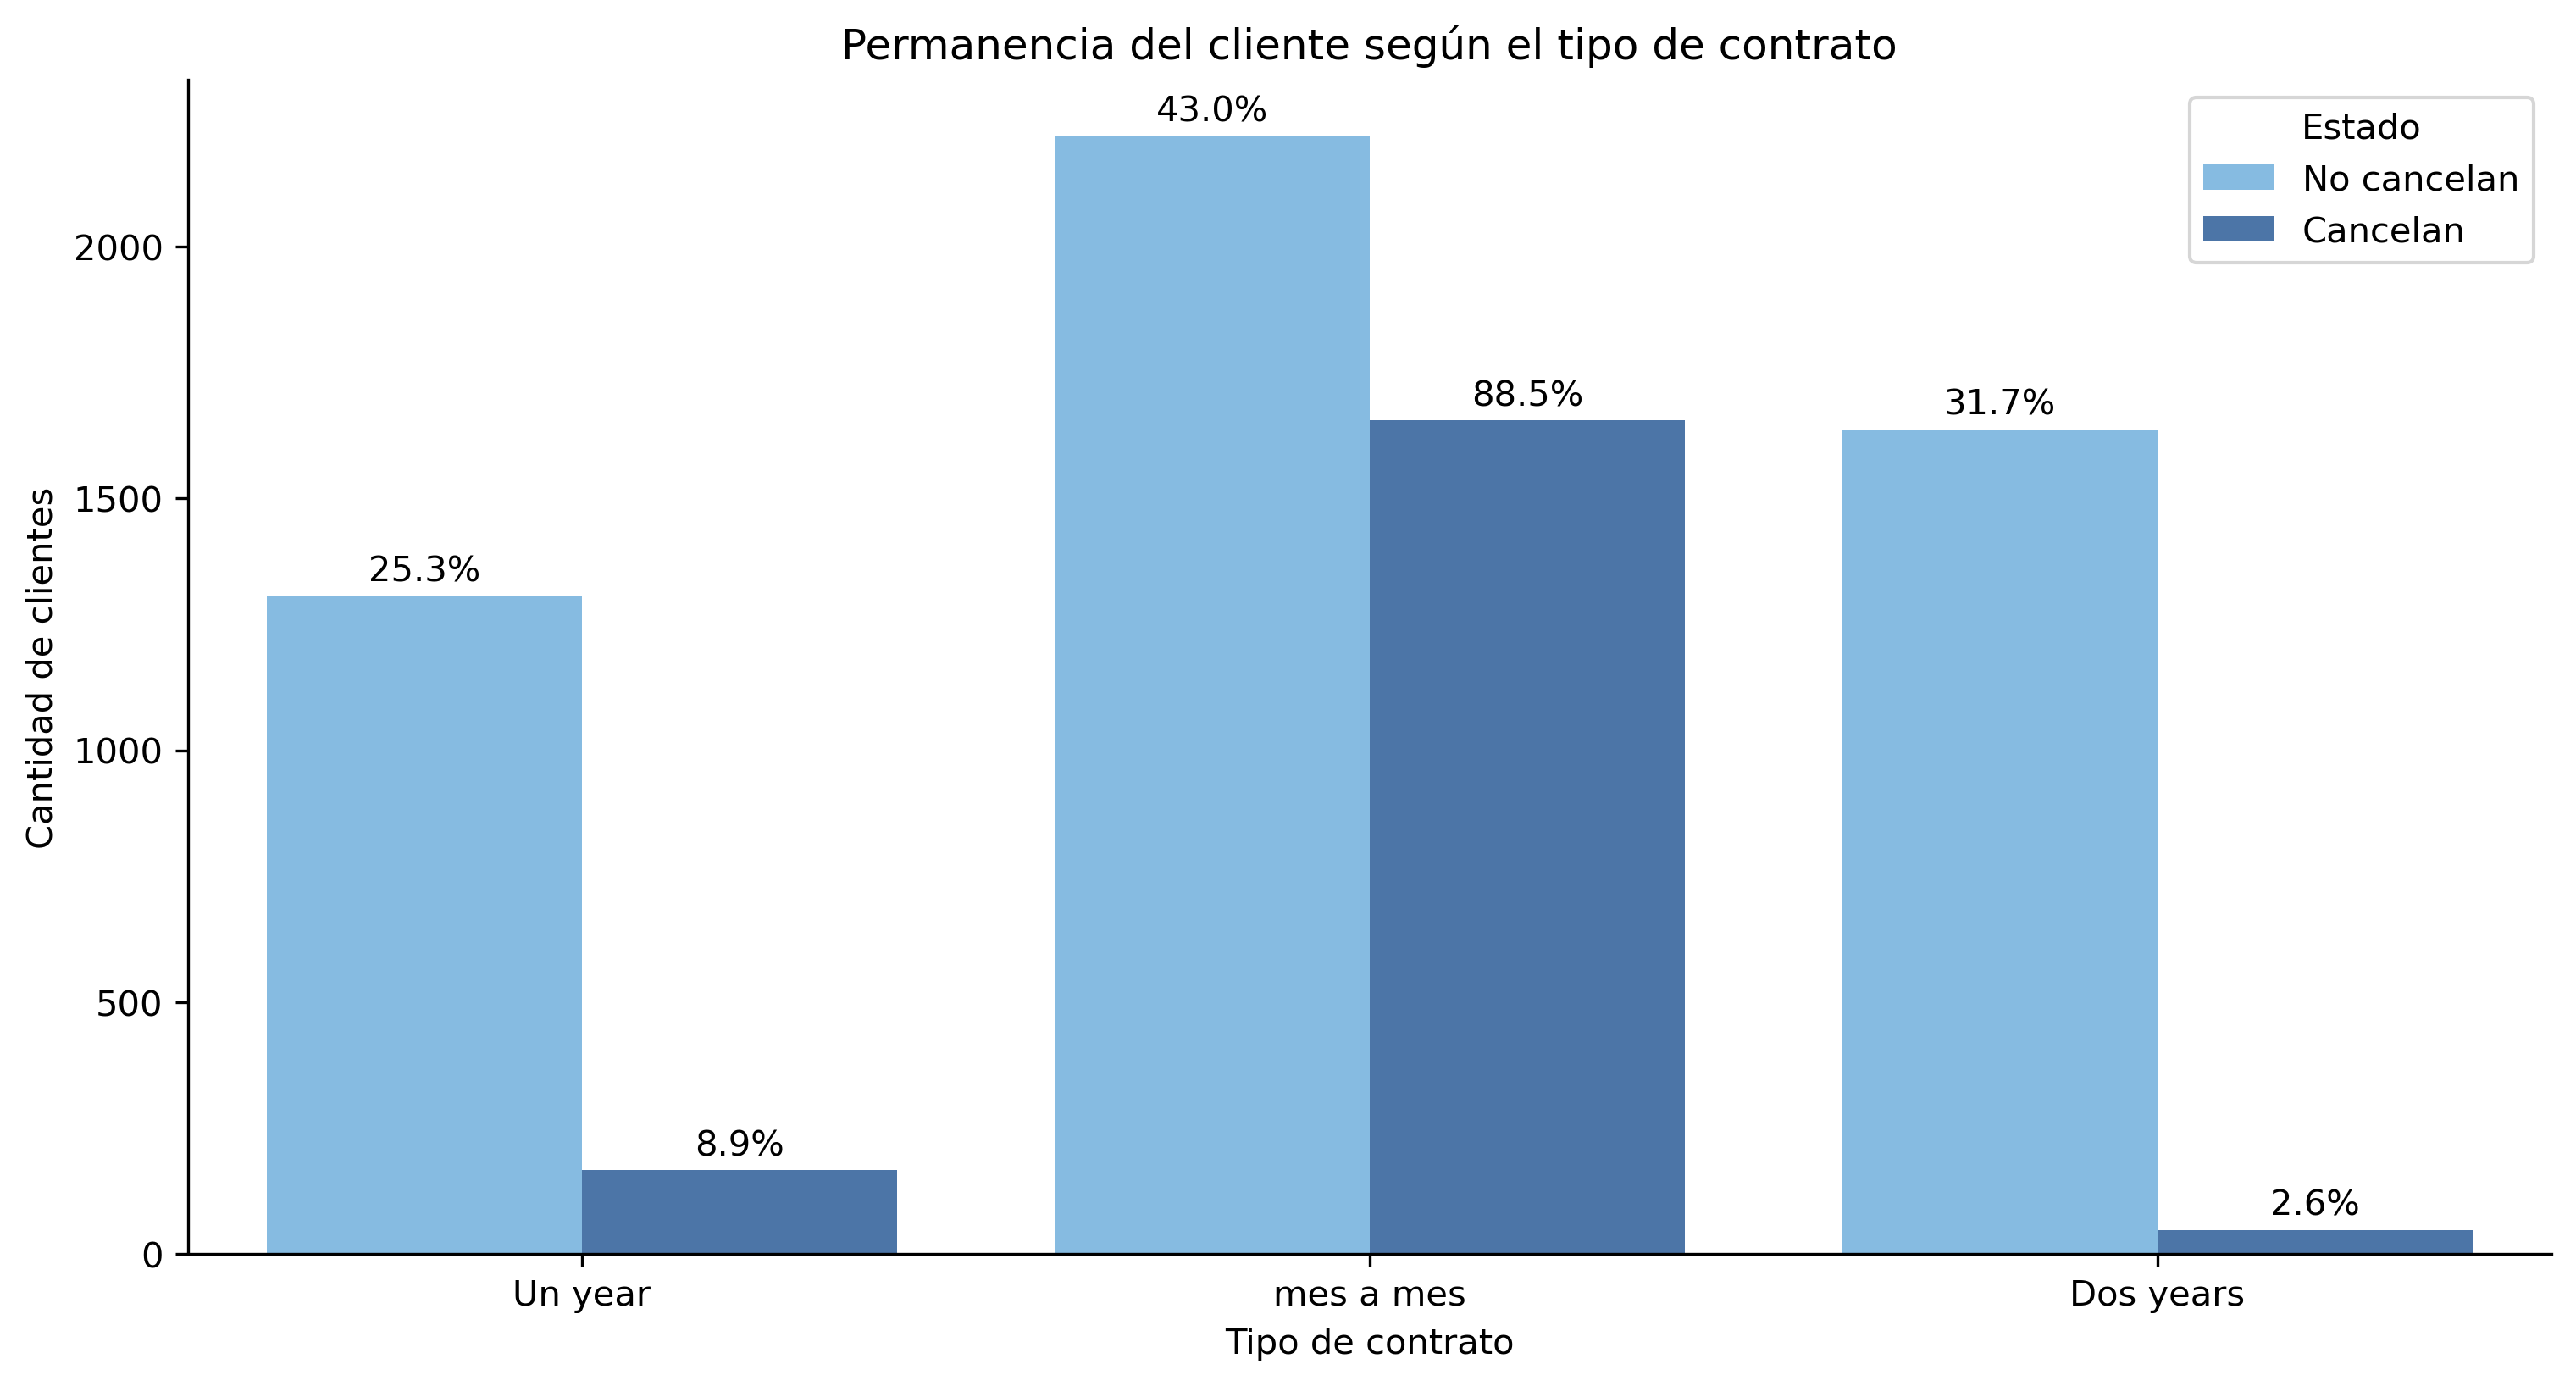

In [116]:
Image('./data_out/permanencia_tipo_contrato.png', width=600)